In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols, mixedlm

import time
from datetime import date





%matplotlib inline


In [2]:
print('hello world')
print(':)')

print(date.today())

hello world
:)
2025-09-10


In [37]:
import sys
print(sys.path[-1])  # should end with .../Fall Analysis 2025/src


C:\Users\jacob\src


In [35]:
import pandas as pd
from pathlib import Path
from IPython.display import display

candidates = [
    Path("target_trial_clean_4.parquet"),
    Path(r"C:\Users\jacob\OneDrive\Desktop\SMC LAB\Projects\Water-Current-Analysis\target_trial_clean_2025_09_09.parquet"),
]

for p in candidates:
    if p.exists():
        df = pd.read_parquet(p)  # engine='pyarrow' by default
        print(f"Loaded: {p}")
        break
else:
    raise FileNotFoundError("Could not find target_trial_clean.parquet at any of the candidate paths.")

display(df.head())
df.info()


#df.to_csv(f'data_{date.today()}.csv', index=False)  


ModuleNotFoundError: No module named 'loading'

In [232]:
print(df['target_angle_90'],df['target_x_label'])



0         77.905243
1         66.801409
2        113.198591
3        102.094757
4        102.094757
            ...    
15867     77.905243
15868     77.905243
15869    113.198591
15870    113.198591
15871     77.905243
Name: target_angle_90, Length: 15872, dtype: float64 0          p0.3
1          p0.6
2        neg0.6
3        neg0.3
4        neg0.3
          ...  
15867      p0.3
15868      p0.3
15869    neg0.6
15870    neg0.6
15871      p0.3
Name: target_x_label, Length: 15872, dtype: object


In [73]:
df['step_delta'] = df['step_2_time'] - df['step_1_time']
df['step_delta']

0        1.81819
1        2.48530
2        3.06009
3        1.39884
4        2.33850
          ...   
15851    1.02200
15852    0.91300
15853    1.24300
15854    0.87500
15855    0.79900
Name: step_delta, Length: 15856, dtype: float64

In [7]:

# function to check if trials exceeded 0.70 m on the z axis
def crossed_z_070(row):
    
    z_vals = [float(z) for z in str(row['ball_pos_z']).split('_') if z]
    
    return max(z_vals) >= 0.7

df['crossed_z_070'] = df.apply(crossed_z_070, axis=1)
df['crossed_z_070']

0        True
1        True
2        True
3        True
4        True
         ... 
15867    True
15868    True
15869    True
15870    True
15871    True
Name: crossed_z_070, Length: 15872, dtype: bool

In [9]:
# check number of trials with z pos less than 70.0 cm
print(df['crossed_z_070'].value_counts()) # only 80 rows did not have a z val equal to or greater than 0.7

df_filt = df[df['crossed_z_070']] # filters out rows that do not equal or exceed 70.0 cm on the z axis

crossed_z_070
True     15785
False       87
Name: count, dtype: int64


In [11]:
# function to extract key data, update columns as needed
def extract_key_data(data):
    cols = ['ppid', 'trial_num', 'trial_num_target', 'launch_deviation', 'launch_Speed', 'ball_dist_to_center_cm', 'target_hit', 
        'water_speed_binary', 'water_speed_m_s', 'target_x_label','sign_label','set_order','training_status',
           'ball_pos_x', 'ball_pos_z', 'target_position_x', 'target_position_z']
    df_small = data[cols].copy()

    # change water_speed_binary to int (from category)
    df_small['water_speed_binary'] = df_small['water_speed_binary'].astype('int8')

    # change training status to ordered category variable
    df_small['training_status'] = pd.Categorical(df_small['training_status'],
                                                categories=['trained','transfer'])
    # change target label to category
    df_small['target_x_label'] = df_small['target_x_label'].astype('category')
    
    # change ppid to category
    df_small['ppid'] = df_small['ppid'].astype('category')

    # make target label categorical
    df_small['target_x_label'] = df_small['target_x_label'].astype('category')

    # make new variable indicating hit or miss
    df_small['hit_state'] = np.where(df_small['target_hit'] == 'True', 1, 0)

    return(df_small)

df_small = extract_key_data(df)
df_small_filt = extract_key_data(df_filt)


In [13]:
print(len(df_small))
print(len(df_small_filt))  # filter worked

15872
15785


In [77]:
display(df_small.head(12))  
df_small.info()

ppid  trial_num  trial_num_target  launch_deviation  launch_Speed  \
0   p000          1                 1        -12.833083      1.121298   
1   p000          2                 1         -5.548219      0.893962   
2   p000          3                 1         -5.863291      0.687646   
3   p000          4                 1          0.443143      1.340726   
4   p000          5                 2         -3.916917      0.859803   
5   p000          6                 2        -16.732929      1.425351   
6   p000          7                 2         -6.590083      0.853114   
7   p000          8                 2         -7.777991      0.778707   
8   p000          9                 3         -2.268983      1.403241   
9   p000         10                 3         -2.954639      1.716756   
10  p000         11                 3         10.872609      1.245419   
11  p000         12                 3         -2.845927      1.116829   

    ball_dist_to_center_cm target_hit  water_speed_binary  water_speed_m_s  \
0                32.167989      False                   0                0   
1                14.809713      False                   0                0   
2                16.184854      False                   0                0   
3                 7.246000       True                   0                0   
4                 9.792754      False                   0                0   
5                44.446199      False                   0                0   
6                16.547623      False                   0                0   
7                21.146697      False                   0                0   
8                 7.302330       True                   0                0   
9                 8.097736       True                   0                0   
10               29.065490      False                   0                0   
11                7.978396       True                   0                0   

   target_x_label sign_label set_order training_status  \
0            p0.3        pos         1             NaN   
1            p0.6        pos         1             NaN   
2          neg0.6        neg         1             NaN   
3          neg0.3        neg         1             NaN   
4          neg0.3        neg         1             NaN   
5            p0.6        pos         1             NaN   
6            p0.3        pos         1             NaN   
7          neg0.6        neg         1             NaN   
8            p0.3        pos         1             NaN   
9            p0.6        pos         1             NaN   
10         neg0.6        neg         1             NaN   
11         neg0.3        neg         1             NaN   

                                           ball_pos_x  \
0   0.000000_0.009428_0.014105_0.018758_0.027994_0...   
1   0.000000_0.008581_0.012845_0.017092_0.025533_0...   
2   0.000000_-0.002049_-0.004091_-0.008157_-0.0101...   
3   0.000000_-0.005803_-0.008678_-0.011535_-0.0171...   
4   0.000000_-0.001223_-0.003655_-0.004863_-0.0060...   
5   0.000000_0.009149_0.027267_0.036237_0.054005_0...   
6   0.000000_0.005455_0.008167_0.010868_0.016238_0...   
7   0.000000_-0.004134_-0.006190_-0.008238_-0.0123...   
8   0.000000_0.003481_0.010376_0.013790_0.017183_0...   
9   0.000000_0.015074_0.022522_0.029912_0.044520_0...   
10  0.000000_-0.013914_-0.020811_-0.034489_-0.0412...   
11  0.000000_-0.001795_-0.003581_-0.007125_-0.0088...   

                                           ball_pos_z  target_position_x  \
0   0.000000_0.020284_0.030348_0.040360_0.060231_0...                0.3   
1   0.000000_0.015643_0.023417_0.031158_0.046547_0...                0.6   
2   0.000000_0.006564_0.013107_0.026132_0.032613_0...               -0.6   
3   0.000000_0.026094_0.039020_0.051868_0.077329_0...               -0.3   
4   0.000000_0.008511_0.025431_0.033841_0.042218_0...               -0.3   
5   0.000000_0.010930_0.032574_0.043291_0.064518_0...                0.6   
6   0.0000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15856 entries, 0 to 15855
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ppid                    15856 non-null  category
 1   trial_num               15856 non-null  int32   
 2   trial_num_target        15856 non-null  int32   
 3   launch_deviation        15856 non-null  float64 
 4   launch_Speed            15856 non-null  float64 
 5   ball_dist_to_center_cm  15856 non-null  float64 
 6   target_hit              15856 non-null  object  
 7   water_speed_binary      15856 non-null  int8    
 8   water_speed_m_s         15856 non-null  int32   
 9   target_x_label          15856 non-null  category
 10  sign_label              15856 non-null  category
 11  set_order               15856 non-null  category
 12  training_status         11644 non-null  category
 13  ball_pos_x              15856 non-null  object  
 14  ball_pos_z            

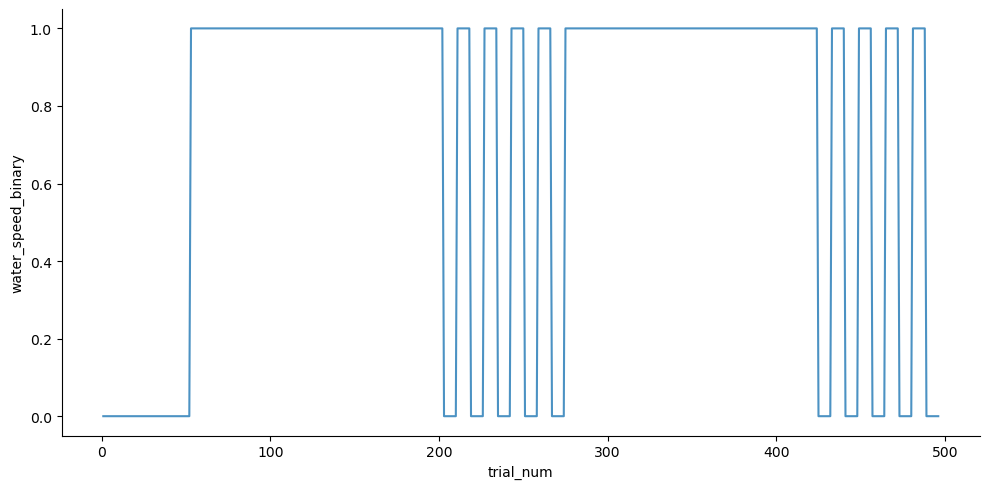

In [35]:

# trial structure plot

# 10 x 5 inches 
g = sns.FacetGrid(df_small, height=5, aspect=2)

g.map_dataframe(
    sns.lineplot,
    x='trial_num', y='water_speed_binary',
    estimator=None, alpha=0.8
)

g.set_axis_labels("trial_num", "water_speed_binary")
g.fig.savefig("trial_structure.pdf", bbox_inches='tight')  
plt.show()


In [15]:

# function to extract the point along the ball trajectory when the ball's z position is closest to the target z position
def point_of_crossing_x(row):

    z_vals = [float(z) for z in row['ball_pos_z'].split('_')]
    x_vals = [float(x) for x in row['ball_pos_x'].split('_')]

    diffs_z = [abs(z - row['target_position_z']) for z in z_vals]
    idx = diffs_z.index(min(diffs_z))

    x_at_closest = x_vals[idx]

    return x_at_closest - row['target_position_x']


df_small['error_x_plane'] = df_small.apply(point_of_crossing_x, axis=1)
df_small_filt['error_x_plane'] = df_small.apply(point_of_crossing_x, axis=1)



# function to extract the point along the ball trajectory when the ball's x position is closest to the target x position
def point_of_crossing_z(row):

    z_vals = [float(z) for z in row['ball_pos_z'].split('_')]
    x_vals = [float(x) for x in row['ball_pos_x'].split('_')]

    diffs_x = [abs(x - row['target_position_x']) for x in x_vals]
    idx = diffs_x.index(min(diffs_x))

    z_at_closest = z_vals[idx]

    return z_at_closest - row['target_position_z']


df_small['error_z_plane'] = df_small.apply(point_of_crossing_z, axis=1)



In [39]:

display(df_small.head())  
df_small.info()

ppid  trial_num  trial_num_target  launch_deviation  launch_Speed  \
0  p000          1                 1        -12.833083      1.121298   
1  p000          2                 1         -5.548219      0.893962   
2  p000          3                 1         -5.863291      0.687646   
3  p000          4                 1          0.443143      1.340726   
4  p000          5                 2         -3.916917      0.859803   

   ball_dist_to_center_cm target_hit  water_speed_binary  water_speed_m_s  \
0               32.167989      False                   0                0   
1               14.809713      False                   0                0   
2               16.184854      False                   0                0   
3                7.246000       True                   0                0   
4                9.792754      False                   0                0   

  target_x_label sign_label set_order training_status  \
0           p0.3        pos         1             NaN   
1           p0.6        pos         1             NaN   
2         neg0.6        neg         1             NaN   
3         neg0.3        neg         1             NaN   
4         neg0.3        neg         1             NaN   

                                          ball_pos_x  \
0  0.000000_0.009428_0.014105_0.018758_0.027994_0...   
1  0.000000_0.008581_0.012845_0.017092_0.025533_0...   
2  0.000000_-0.002049_-0.004091_-0.008157_-0.0101...   
3  0.000000_-0.005803_-0.008678_-0.011535_-0.0171...   
4  0.000000_-0.001223_-0.003655_-0.004863_-0.0060...   

                                          ball_pos_z  target_position_x  \
0  0.000000_0.020284_0.030348_0.040360_0.060231_0...                0.3   
1  0.000000_0.015643_0.023417_0.031158_0.046547_0...                0.6   
2  0.000000_0.006564_0.013107_0.026132_0.032613_0...               -0.6   
3  0.000000_0.026094_0.039020_0.051868_0.077329_0...               -0.3   
4  0.000000_0.008511_0.025431_0.033841_0.042218_0...               -0.3   

   target_position_z  hit_state  error_x_plane  error_z_plane  
0                1.4          0       0.301491      -0.754714  
1                1.4          0       0.132410      -0.308687  
2                1.4          0       0.164926      -0.006168  
3                1.4          1       0.009419      -0.093360  
4                1.4          0       0.099415      -0.004214

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15872 entries, 0 to 15871
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ppid                    15872 non-null  category
 1   trial_num               15872 non-null  int32   
 2   trial_num_target        15872 non-null  int32   
 3   launch_deviation        15872 non-null  float64 
 4   launch_Speed            15872 non-null  float64 
 5   ball_dist_to_center_cm  15872 non-null  float64 
 6   target_hit              15872 non-null  object  
 7   water_speed_binary      15872 non-null  int8    
 8   water_speed_m_s         15872 non-null  int32   
 9   target_x_label          15872 non-null  category
 10  sign_label              15872 non-null  category
 11  set_order               15872 non-null  category
 12  training_status         11648 non-null  category
 13  ball_pos_x              15872 non-null  object  
 14  ball_pos_z            

In [17]:
# number of participants
ppid_list = df_small['ppid']
print(f'Number of Participants in data: {len(ppid_list.unique())}')

# check number of ppid per set order:
counts = np.array(df_small.groupby('set_order')['ppid'].nunique().reset_index())
print(counts)

# set order 1 n
n_1 = counts[0,1]

# set order 2 n
n_2 = counts[1,1]

Number of Participants in data: 31
[['1' 17]
 ['2' 14]]


C:\Users\jacob\AppData\Local\Temp\ipykernel_12740\495388873.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = np.array(df_small.groupby('set_order')['ppid'].nunique().reset_index())


In [43]:
# power

# s1 group:
print(n_1)
# s2 group
print(n_2)

17
14


In [21]:
# function to extract water current transition points
# may be used to identify phases and associated trial numbers


def transition_trials(df):
    
    df = df.sort_values('trial_num')  # ensure order
    
    df['changed'] = df['water_speed_binary'] != df['water_speed_binary'].shift(1)
    df['changed_state'] = df['water_speed_binary'].where(df['changed'])
    
    return(df)

transitions = transition_trials(df_small)

print(transitions.groupby(['trial_num'])['changed']==True)


False


In [23]:
# view transition trials
counts = (transitions
    .value_counts(['trial_num', 'changed_state', 'water_speed_binary'], dropna=True)
    .reset_index()
    .sort_values(['trial_num','changed_state','water_speed_binary']))

# only include active-water trials
#counts = counts.loc[counts['water_speed_binary'] == 1]
print(counts.to_string(index=False))



transition_trials = (counts.query('changed_state == 1 and water_speed_binary == 1')[['trial_num']].drop_duplicates())


 trial_num  changed_state  water_speed_binary  count
         1            0.0                   0      1
        53            1.0                   1      1
       203            0.0                   0      1
       211            1.0                   1      1
       219            0.0                   0      1
       227            1.0                   1      1
       235            0.0                   0      1
       243            1.0                   1      1
       251            0.0                   0      1
       259            1.0                   1      1
       267            0.0                   0      1
       275            1.0                   1      1
       425            0.0                   0      1
       433            1.0                   1      1
       441            0.0                   0      1
       449            1.0                   1      1
       457            0.0                   0      1
       465            1.0                   1 

In [19]:
def all_trials_base(df):
    base = df.query('trial_num_target <= 13 and water_speed_binary == 0').copy()
    base = base.sort_values(['ppid','target_x_label','trial_num_target'])
    base_summary = (base
        .groupby(['ppid','target_x_label'], as_index=False)
        .agg(baseline_dist_cm=('ball_dist_to_center_cm','mean'),
             baseline_error_x=('error_x_plane','mean'),
             hit_rate=('hit_state','mean')))
    return base_summary

baseline = all_trials_base(df_small)

baseline_filt = all_trials_base(df_small_filt)

C:\Users\jacob\AppData\Local\Temp\ipykernel_12740\1216978990.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['ppid','target_x_label'], as_index=False)
C:\Users\jacob\AppData\Local\Temp\ipykernel_12740\1216978990.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['ppid','target_x_label'], as_index=False)


In [21]:
# combine baseline error back to main df
df_small = df_small.merge(baseline, on=['ppid', 'target_x_label'], how='left')

df_small_filt = df_small_filt.merge(baseline_filt, on=['ppid', 'target_x_label'], how='left')


# baseline correct min distance DV
df_small['baseline_corrected_dist'] = df_small['ball_dist_to_center_cm'] - df_small['baseline_dist_cm']
df_small['baseline_corrected_x'] = df_small['error_x_plane'] - df_small['baseline_error_x']

# filtered data baseline correct
df_small_filt['baseline_corrected_dist'] = df_small_filt['ball_dist_to_center_cm'] - df_small_filt['baseline_dist_cm']





In [23]:
df_small

ppid  trial_num  trial_num_target  launch_deviation  launch_Speed  \
0      p000          1                 1        -12.833083      1.121298   
1      p000          2                 1         -5.548219      0.893962   
2      p000          3                 1         -5.863291      0.687646   
3      p000          4                 1          0.443143      1.340726   
4      p000          5                 2         -3.916917      0.859803   
...     ...        ...               ...               ...           ...   
15867  p037        492               122         -2.166763      1.868143   
15868  p037        493               123         -1.201723      2.068898   
15869  p037        494               123         -4.332791      1.714144   
15870  p037        495               124          1.787509      2.412205   
15871  p037        496               124         -1.978963      2.411767   

       ball_dist_to_center_cm target_hit  water_speed_binary  water_speed_m_s  \
0                   32.167989      False                   0                0   
1                   14.809713      False                   0                0   
2                   16.184854      False                   0                0   
3                    7.246000       True                   0                0   
4                    9.792754      False                   0                0   
...                       ...        ...                 ...              ...   
15867                7.516638       True                   0                0   
15868                7.041025       True                   0                0   
15869               11.837030      False                   0                0   
15870                7.110907       True                   0                0   
15871                6.133657       True                   0                0   

      target_x_label  ... target_position_x target_position_z hit_state  \
0               p0.3  ...               0.3               1.4         0   
1               p0.6  ...               0.6               1.4         0   
2             neg0.6  ...              -0.6               1.4         0   
3             neg0.3  ...              -0.3               1.4         1   
4             neg0.3  ...              -0.3               1.4         0   
...              ...  ...               ...               ...       ...   
15867           p0.3  ...               0.3               1.4         1   
15868           p0.3  ...               0.3               1.4         1   
15869         neg0.6  ...              -0.6               1.4         0   
15870         neg0.6  ...              -0.6               1.4         1   
15871           p0.3  ...               0.3               1.4         1   

      error_x_plane error_z_plane  baseline_dist_cm  baseline_error_x  \
0          0.301491     -0.754714         28.365576          0.188489   
1          0.132410     -0.308687         14.567456          0.077728   
2          0.164926     -0.006168         16.097541          0.065391   
3          0.009419     -0.093360         17.120485          0.121472   
4          0.099415     -0.004214         17.120485          0.121472   
...             ...           ...               ...               ...   
15867      0.032263     -0.212746         10.971750          0.071752   
15868      0.006927     -0.123112         10.971750          0.071752   
15869      0.126262     -0.013626          7.990968          0.025822   
15870     -0.010323     -0.112896          7.990968          0.025822   
15871      0.029810     -0.213389         10.971750          0.071752   

       hit_rate  baseline_corrected_dist  baseline_corrected_x  
0      0.384615                 3.802412              0.113002  
1      0.384615                 0.242257              0.054682  
2      0.307692                 0.087312              0.099535  
3      0.384615                -9.874484             -0.112053  
4      0.384615   

In [174]:
df_small_filt

ppid  trial_num  trial_num_target  launch_deviation  launch_Speed  \
0      p000          1                 1        -12.833083      1.121298   
1      p000          2                 1         -5.548219      0.893962   
2      p000          3                 1         -5.863291      0.687646   
3      p000          4                 1          0.443143      1.340726   
4      p000          5                 2         -3.916917      0.859803   
...     ...        ...               ...               ...           ...   
15771  p037        492               122         -2.166763      1.868143   
15772  p037        493               123         -1.201723      2.068898   
15773  p037        494               123         -4.332791      1.714144   
15774  p037        495               124          1.787509      2.412205   
15775  p037        496               124         -1.978963      2.411767   

       ball_dist_to_center_cm target_hit  water_speed_binary  water_speed_m_s  \
0                   32.167989      False                   0                0   
1                   14.809713      False                   0                0   
2                   16.184854      False                   0                0   
3                    7.246000       True                   0                0   
4                    9.792754      False                   0                0   
...                       ...        ...                 ...              ...   
15771                7.516638       True                   0                0   
15772                7.041025       True                   0                0   
15773               11.837030      False                   0                0   
15774                7.110907       True                   0                0   
15775                6.133657       True                   0                0   

      target_x_label  ...                                         ball_pos_x  \
0               p0.3  ...  0.000000_0.009428_0.014105_0.018758_0.027994_0...   
1               p0.6  ...  0.000000_0.008581_0.012845_0.017092_0.025533_0...   
2             neg0.6  ...  0.000000_-0.002049_-0.004091_-0.008157_-0.0101...   
3             neg0.3  ...  0.000000_-0.005803_-0.008678_-0.011535_-0.0171...   
4             neg0.3  ...  0.000000_-0.001223_-0.003655_-0.004863_-0.0060...   
...              ...  ...                                                ...   
15771           p0.3  ...  0.000000_0.009165_0.013688_0.018173_0.027030_0...   
15772           p0.3  ...  0.000000_0.009471_0.014139_0.018764_0.027884_0...   
15773         neg0.6  ...  0.000000_-0.005543_-0.016497_-0.021910_-0.0326...   
15774         neg0.6  ...  0.000000_-0.010189_-0.020265_-0.040085_-0.0498...   
15775           p0.3  ...  0.000000_0.005865_0.017400_0.023072_0.034236_0...   

                                              ball_pos_z target_position_x  \
0      0.000000_0.020284_0.030348_0.040360_0.060231_0...               0.3   
1      0.000000_0.015643_0.023417_0.031158_0.046547_0...               0.6   
2      0.000000_0.006564_0.013107_0.026132_0.032613_0...              -0.6   
3      0.000000_0.026094_0.039020_0.051868_0.077329_0...              -0.3   
4      0.000000_0.008511_0.025431_0.033841_0.042218_0...              -0.3   
...                                                  ...               ...   
15771  0.000000_0.036055_0.053851_0.071496_0.106343_0...               0.3   
15772  0.000000_0.040076_0.059829_0.079397_0.117991_0...               0.3   
15773  0.000000_0.016221_0.048278_0.064120_0.095437_0...              -0.6   
15774  0.000000_0.021864_0.043485_0.086017_0.106939_0...              -0.6   
15775  0.000000_0.023394_0.069405_0.092034_0.136565_0...               0.3   

      target_position_z hit_state  error_x_plane  baseline_dist_cm  \
0                   1.4         0       0.301491         16.219834   
1                   1.4         0       0.132410         14.567456   
2            

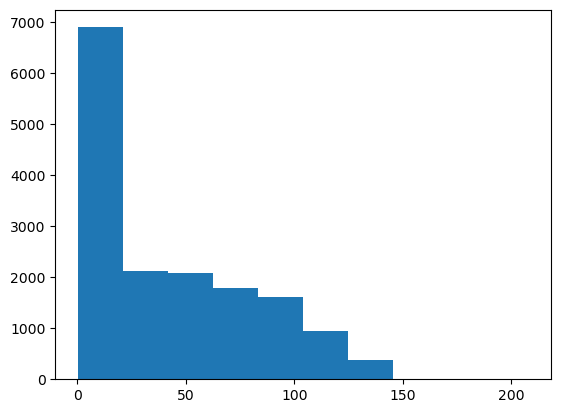

In [25]:
# histogram of baseline errors
plt.hist(df_small['ball_dist_to_center_cm']) 
plt.show()

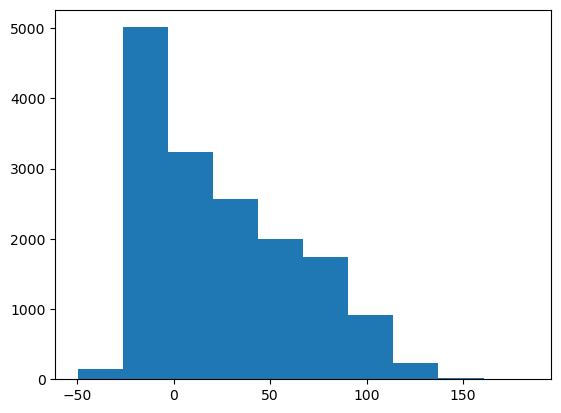

In [27]:
plt.hist(df_small['baseline_corrected_dist'])
plt.show()

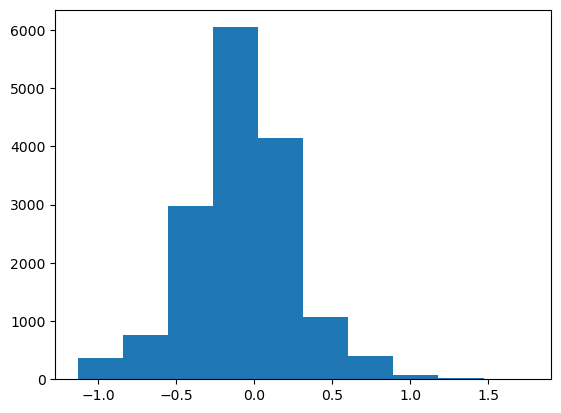

In [53]:
# histogram of baseline errors
plt.hist(df_small['baseline_corrected_x'])
plt.show()

C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

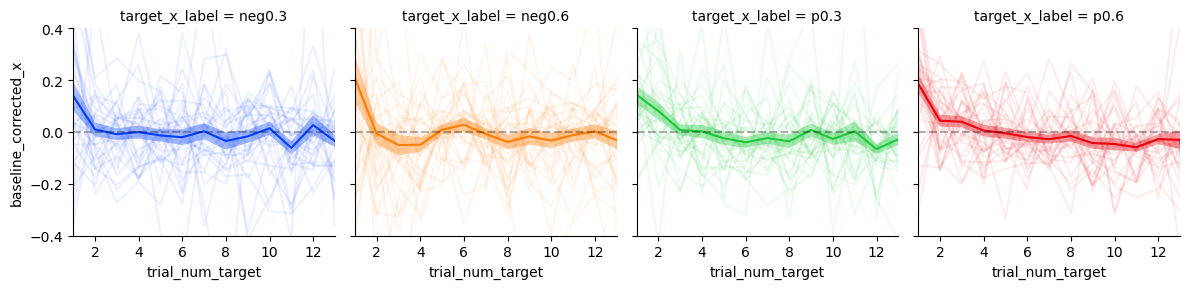

In [55]:
# set facets by target
g = sns.FacetGrid(df_small, col='target_x_label', sharex=False, sharey=True)
# set Y lim to 40.0 cm
g.set(ylim=(-0.4, 0.4))
g.set(xlim=(1, 13))


# individual data
g.map_dataframe(sns.lineplot,
                x='trial_num_target', y='baseline_corrected_x',
                estimator=None, units='ppid',
                hue = 'target_x_label', palette='bright',
                alpha=0.075)
# mean line and se bands
g.map_dataframe(sns.lineplot,
                x='trial_num_target', y='baseline_corrected_x',
                estimator='mean', errorbar='se', err_kws={'alpha':0.35, 'linewidth':0},
                hue = 'target_x_label', palette='bright', alpha=1)

# add horizontal line at error of 0
for ax in g.axes.flat:
    ax.axhline(y=0.0, color = 'black', linestyle='--', alpha = 0.3)


# Save and display
plt.savefig("baseline_x_per_target.pdf", dpi=300, bbox_inches="tight")
plt.show()

C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

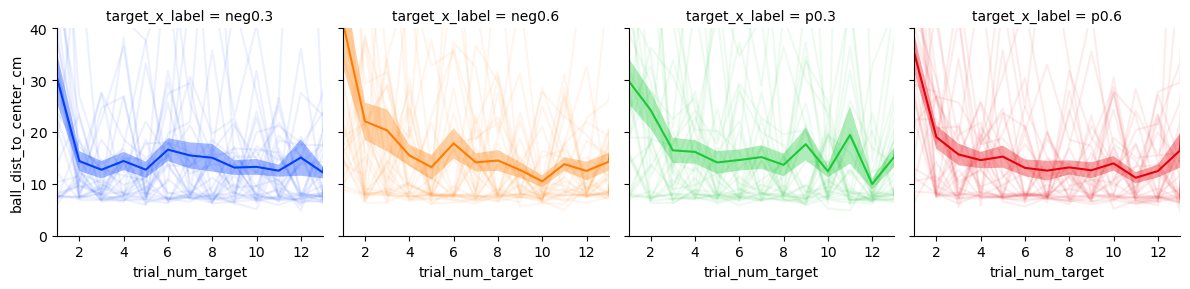

In [248]:
# set facets by target
g = sns.FacetGrid(df_small, col='target_x_label', sharex=False, sharey=True)
# set Y lim to 40.0 cm
g.set(ylim=(None, 40.0))
g.set(xlim=(1, 13))


# individual data
g.map_dataframe(sns.lineplot,
                x='trial_num_target', y='ball_dist_to_center_cm',
                estimator=None, units='ppid',
                hue = 'target_x_label', palette='bright',
                alpha=0.075)
# mean line and se bands
g.map_dataframe(sns.lineplot,
                x='trial_num_target', y='ball_dist_to_center_cm',
                estimator='mean', errorbar='se', err_kws={'alpha':0.35, 'linewidth':0},
                hue = 'target_x_label', palette='bright', alpha=1)

# Save and display
plt.savefig("baseline_per_target_2025_09_09.pdf", dpi=300, bbox_inches="tight")
plt.show()

C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

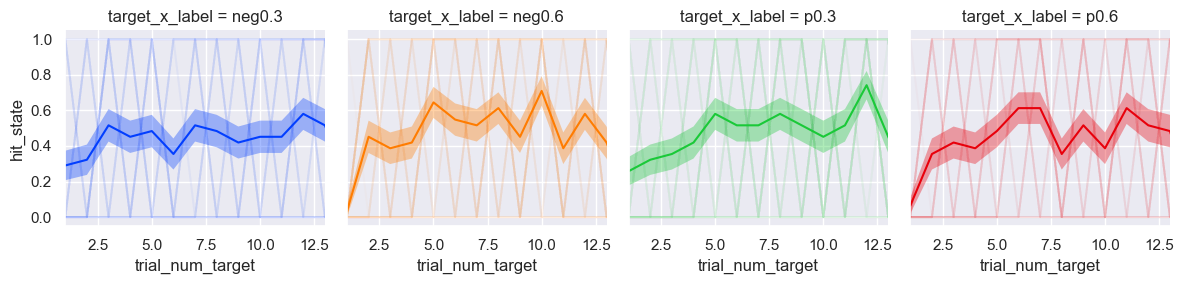

In [592]:
# set facets by target
g = sns.FacetGrid(df_small, col='target_x_label', sharex=False, sharey=True)
# set Y lim to 110.0 cm
g.set(xlim=(1, 13))


# individual data
g.map_dataframe(sns.lineplot,
                x='trial_num_target', y='hit_state',
                estimator=None, units='ppid',
                hue = 'target_x_label', palette='bright',
                alpha=0.025)
# mean line and se bands
g.map_dataframe(sns.lineplot,
                x='trial_num_target', y='hit_state',
                estimator='mean', errorbar='se', err_kws={'alpha':0.35, 'linewidth':0},
                hue = 'target_x_label', palette='bright', alpha=1)

# Save and display
plt.savefig("baseline_per_target.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [932]:
def first10_last10_means_exp(df, min_b1, max_b1, min_b2, max_b2, error_col, include_status=False):
    # filter to exposure windows
    df_exp = df[df['trial_num'].between(min_b1, max_b1) | df['trial_num'].between(min_b2, max_b2)].copy()

    # label blocks
    if not (max_b2 > max_b1):
        raise ValueError("max_b2 must be > max_b1.")
    df_exp['block'] = np.where(df_exp['trial_num'] <= max_b1, 1, 2)

    # ensure an order column
    order_col = 'trial_num_target' if 'trial_num_target' in df_exp.columns else 'trial_num'

    # sort ALIGNED with group
    ordered = (df_exp
               .sort_values(['ppid','target_x_label','block', order_col])
               .groupby(['ppid','target_x_label','block'], group_keys=False, observed=True))

    # slice + de-overlap
    first10     = ordered.head(10).assign(section='first10')
    last10_all  = ordered.tail(10).assign(section='last10')
    last10      = last10_all[~last10_all.index.isin(first10.index)]  # <-- key line
    combined_10 = pd.concat([first10, last10], ignore_index=True)

    # aggregate
    groupby_cols = ['ppid','section','target_x_label','set_order','block']
    if include_status and 'training_status' in df_exp.columns:
        groupby_cols.append('training_status')

    df_aov = (combined_10.groupby(groupby_cols, as_index=False, observed=True)
              .agg(mean_dist=(error_col, 'mean'),
                   var_dist=(error_col, lambda s: s.var(ddof=1)),
                   n=(order_col, 'size')))

    df_aov['section'] = pd.Categorical(df_aov['section'], ['first10','last10'], ordered=True)
    return df_aov



In [29]:
def first10_last10_means_exp(
    df, min_b1, max_b1, min_b2, max_b2, error_col,
    include_status=False  # set True if you want training_status as a factor
):

        
    # Function to extract the first and last 10 trials within a set range.
    # In the current experiment there are two 'blocks' of exposure to the
    # active water current.
    
    # min_b1: refers to the first trial of the first exposure block
    # max_b2: refers to the final trial of the second exposure block


    
    # keep only exposure trials from the two windows
    df_exp = df[df['trial_num'].between(min_b1, max_b1) |
                df['trial_num'].between(min_b2, max_b2)].copy()

    # label exposure block 1 vs 2
    df_exp['block'] = np.where(df_exp['trial_num'] <= max_b1, 1, 2)

    # order within each (ppid, target, block) by trial order
    ordered = (df_exp
               .sort_values(['ppid','target_x_label','block','trial_num_target'])
               .groupby(['ppid','target_x_label','block'], group_keys=False))

    counts = (df_exp.groupby(['ppid','target_x_label','block'], observed=True)
                .size())
    #print(counts)


    # take first/last 10 trials per (ppid, target, block)
    first10 = ordered.head(10).assign(section='first10')
    
    last10_all  = ordered.tail(10).assign(section='last10')
    last10 = last10_all[~last10_all.index.isin(first10.index)]

    combined_10 = pd.concat([first10, last10], ignore_index=True)

    # store trial_num_target lists for each grouping
    trial_lists = (
        combined_10.groupby(['ppid','target_x_label','block','section'])
                   .agg(trial_list=('trial_num_target', list))
                   .reset_index()
    )

    print('Trial lists:')
    print(trial_lists)


    # collapse to ONE row per subject x cell for ANOVA
    groupby_cols = ['ppid','section','target_x_label','set_order','block']
    if include_status:
        groupby_cols.append('training_status')  
        
    df_aov = (combined_10.groupby(groupby_cols, as_index=False, observed=True)
              .agg(mean_dist=(error_col, 'mean'),
                   var_dist=(error_col, 'var'),   
                   n=('trial_num_target', 'size')))

    # ordered factor for section
    df_aov['section'] = pd.Categorical(df_aov['section'], ['first10','last10'], ordered=True)
    
    return df_aov


In [31]:

combined_10_means = first10_last10_means_exp(df_small, min_b1=53, max_b1=202, min_b2=275, max_b2=424, error_col='baseline_corrected_dist', include_status=True)
# ball_dist_to_center_cm
# baseline_corrected_dist

display(combined_10_means)


Trial lists:
     ppid target_x_label  block  section  \
0    p000         neg0.3      1  first10   
1    p000         neg0.3      1   last10   
2    p000         neg0.3      2  first10   
3    p000         neg0.3      2   last10   
4    p000         neg0.6      1  first10   
..    ...            ...    ...      ...   
491  p037           p0.3      2   last10   
492  p037           p0.6      1  first10   
493  p037           p0.6      1   last10   
494  p037           p0.6      2  first10   
495  p037           p0.6      2   last10   

                                   trial_list  
0                                         NaN  
1                                         NaN  
2    [14, 15, 16, 17, 18, 19, 20, 21, 22, 23]  
3    [79, 80, 81, 82, 83, 84, 85, 86, 87, 88]  
4    [14, 15, 16, 17, 18, 19, 20, 21, 22, 23]  
..                                        ...  
491  [79, 80, 81, 82, 83, 84, 85, 86, 87, 88]  
492  [14, 15, 16, 17, 18, 19, 20, 21, 22, 23]  
493  [79, 80, 81, 82, 83, 

C:\Users\jacob\AppData\Local\Temp\ipykernel_12740\191227719.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['ppid','target_x_label','block'], group_keys=False))
C:\Users\jacob\AppData\Local\Temp\ipykernel_12740\191227719.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined_10.groupby(['ppid','target_x_label','block','section'])


ppid  section target_x_label set_order  block training_status  mean_dist  \
0    p000  first10         neg0.3         1      2        transfer  28.393533   
1    p000  first10         neg0.6         1      1         trained  36.870157   
2    p000  first10           p0.3         1      1         trained  38.374336   
3    p000  first10           p0.6         1      2        transfer  76.090083   
4    p000   last10         neg0.3         1      2        transfer  -3.978281   
..    ...      ...            ...       ...    ...             ...        ...   
251  p037  first10           p0.6         2      1         trained  49.361826   
252  p037   last10         neg0.3         2      1         trained  27.626343   
253  p037   last10         neg0.6         2      2        transfer  29.354386   
254  p037   last10           p0.3         2      2        transfer  26.389120   
255  p037   last10           p0.6         2      1         trained  55.398126   

        var_dist   n  
0    1368.492609  10  
1     753.769148  10  
2      30.536705  10  
3    3533.883662  10  
4     207.091374  10  
..           ...  ..  
251  2194.012284  10  
252   536.065264  10  
253   451.913429  10  
254  1544.235621  10  
255  4103.071515  10  

[256 rows x 9 columns]

In [254]:

combined_10_means_filt = first10_last10_means_exp(df_small_filt, min_b1=53, max_b1=202, min_b2=275, max_b2=424, error_col='baseline_corrected_dist', include_status=True)
# ball_dist_to_center_cm
# baseline_corrected_dist

display(combined_10_means_filt)


ppid  target_x_label  block
p000  neg0.3          2        74
      neg0.6          1        73
      p0.3            1        75
      p0.6            2        75
p002  neg0.3          1        75
                               ..
p036  p0.6            2        75
p037  neg0.3          1        75
      neg0.6          2        75
      p0.3            2        75
      p0.6            1        75
Length: 128, dtype: int64


C:\Users\jacob\AppData\Local\Temp\ipykernel_10364\63586986.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['ppid','target_x_label','block'], group_keys=False))


ppid  section target_x_label set_order  block training_status  mean_dist  \
0    p000  first10         neg0.3         1      2        transfer  28.393533   
1    p000  first10         neg0.6         1      1         trained  22.886913   
2    p000  first10           p0.3         1      1         trained  50.520079   
3    p000  first10           p0.6         1      2        transfer  76.090083   
4    p000   last10         neg0.3         1      2        transfer  -3.978281   
..    ...      ...            ...       ...    ...             ...        ...   
251  p037  first10           p0.6         2      1         trained  49.361826   
252  p037   last10         neg0.3         2      1         trained  27.626343   
253  p037   last10         neg0.6         2      2        transfer  29.354386   
254  p037   last10           p0.3         2      2        transfer  26.389120   
255  p037   last10           p0.6         2      1         trained  55.398126   

        var_dist   n  
0    1368.492609  10  
1     431.704467  10  
2      30.536705  10  
3    3533.883662  10  
4     207.091374  10  
..           ...  ..  
251  2194.012284  10  
252   536.065264  10  
253   451.913429  10  
254  1544.235621  10  
255  4103.071515  10  

[256 rows x 9 columns]

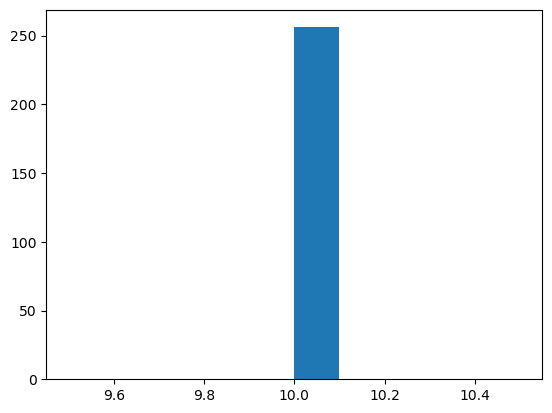

In [300]:
# histogram of baseline errors
plt.hist(combined_10_means['n']) 
plt.show()

C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*pl

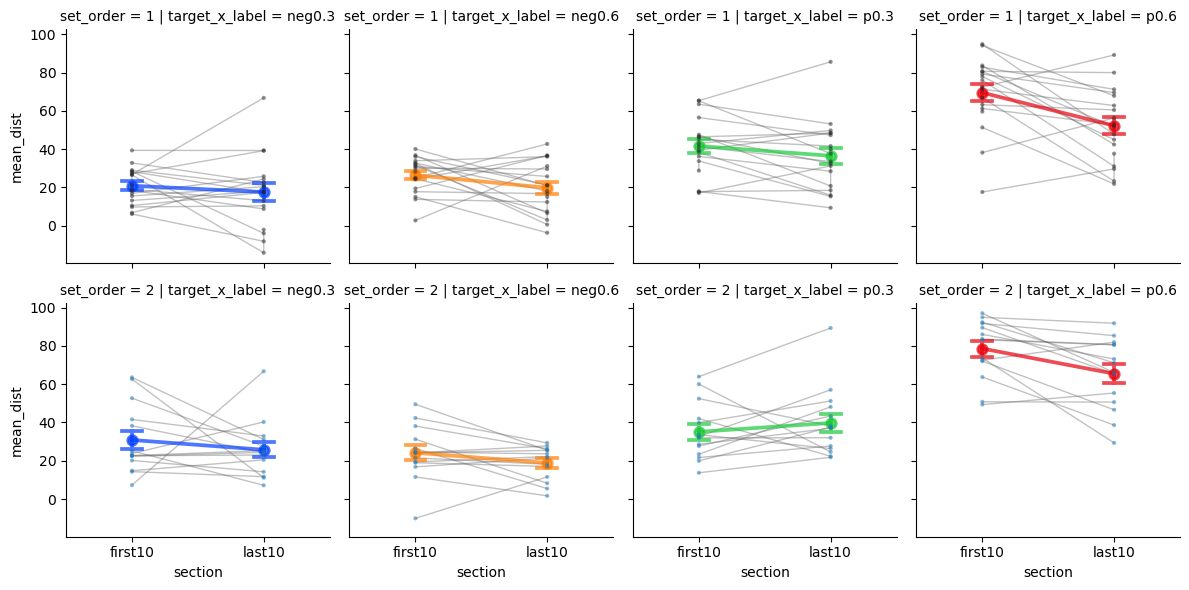

In [33]:
# first and last 10 trials of exposure
g = sns.FacetGrid(combined_10_means, col = 'target_x_label', row='set_order')

# individual participant data points
g.map_dataframe(sns.stripplot,
                x='section', y='mean_dist',
                order=['first10','last10'],
                hue='set_order',
                jitter=0.0, alpha=0.5, size=3, linewidth=0
               )
# individual participant lines
g.map_dataframe(sns.lineplot,
                x='section', y='mean_dist',
                units='ppid', estimator=None, color='0.4',
                alpha=0.4, linewidth=1
               )

# mean line and se bands
g.map_dataframe(sns.pointplot,
                x='section', y='mean_dist',
                order=['first10','last10'],
                hue='target_x_label', palette='bright', alpha = 0.7,
                estimator=np.mean, errorbar='se', capsize=.15
               )

# Save and display
plt.savefig("first10_last10_exposure.pdf", dpi=300, bbox_inches="tight")
plt.show()

C:\Users\jacob\AppData\Local\Temp\ipykernel_10364\260657197.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  combined_10_means.pivot_table(


ppid target_x_label set_order block training_status  mean_dist  \
section                                                         first10   
0        p000         neg0.3         1     2        transfer  28.393533   
1        p000         neg0.6         1     1         trained  36.870157   
2        p000           p0.3         1     1         trained  38.374336   
3        p000           p0.6         1     2        transfer  76.090083   
4        p002         neg0.3         2     1         trained  22.629865   
..        ...            ...       ...   ...             ...        ...   
123      p036           p0.6         1     2        transfer  61.253830   
124      p037         neg0.3         2     1         trained  52.718090   
125      p037         neg0.6         2     2        transfer  42.343443   
126      p037           p0.3         2     2        transfer  33.614927   
127      p037           p0.6         2     1         trained  49.361826   

                       var_dist              mean_dist_diff var_dist_diff  
section     last10      first10       last10                               
0        -3.978281  1368.492609   207.091374     -32.371814  -1161.401235  
1         6.575669   753.769148   198.065239     -30.294488   -555.703908  
2        15.911903    30.536705  2585.988982     -22.462434   2555.452277  
3        31.043413  3533.883662  3892.719133     -45.046670    358.835471  
4        23.002891   246.364413   440.927315       0.373025    194.562902  
..             ...          ...          ...            ...           ...  
123      52.822954  2036.767652  3648.490646      -8.430877   1611.722994  
124      27.626343   320.610749   536.065264     -25.091747    215.454515  
125      29.354386   418.575839   451.913429     -12.989058     33.337589  
126      26.389120  1065.342820  1544.235621      -7.225807    478.892801  
127      55.398126  2194.012284  4103.071515       6.036300   1909.059231  

[128 rows x 11 columns]

C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*pl

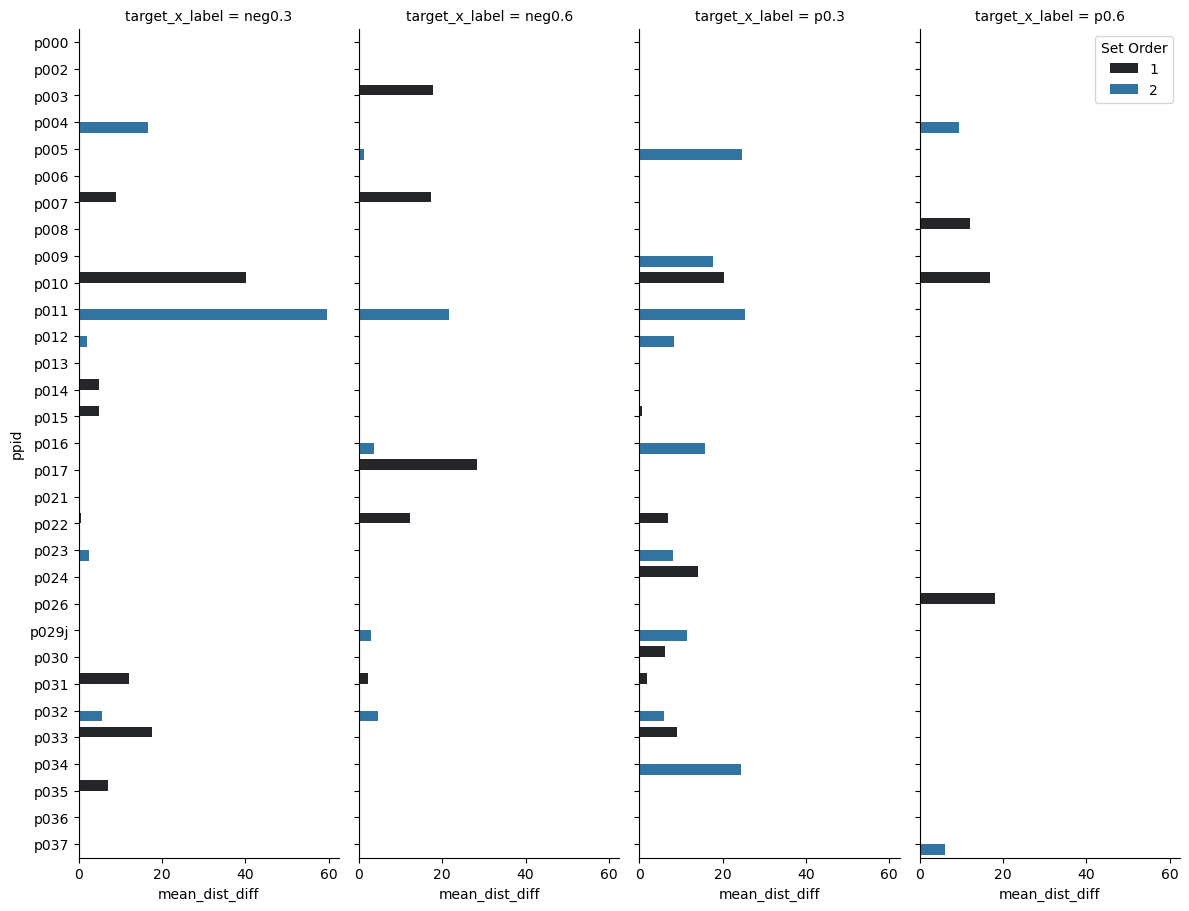

In [298]:
combined_10_means_diff = (
    combined_10_means.pivot_table(
        index=["ppid", "target_x_label", "set_order", "block", "training_status"],
        columns="section",
        values=["mean_dist", "var_dist"]
    )
)

# compute difference: last10 - first10
combined_10_means_diff["mean_dist_diff"] = combined_10_means_diff["mean_dist"]["last10"] - combined_10_means_diff["mean_dist"]["first10"]
combined_10_means_diff["var_dist_diff"]  = combined_10_means_diff["var_dist"]["last10"] - combined_10_means_diff["var_dist"]["first10"]

combined_10_means_diff = combined_10_means_diff.reset_index()

display(combined_10_means_diff)

# filter df so we only have ppid who had positive differences
combined_10_means_diff_worse = combined_10_means_diff[combined_10_means_diff['mean_dist_diff'] > 0]



# First and last 10 trials of exposure mean differences
g = sns.FacetGrid(combined_10_means_diff_worse, col='target_x_label', sharex=True)

# Individual participant data points
g.map_dataframe(sns.barplot, 
                x='mean_dist_diff', 
                y='ppid',
                hue='set_order')

# Add shading (x < 0) to indicate improvement zone
for ax in g.axes.flat:
    ax.axvspan(ax.get_xlim()[0], 0, color="gray", alpha=0.2)

# legend
plt.legend(title="Set Order")

# Save and display
g.fig.set_size_inches(12, 12) 
plt.savefig("ppid_diff.pdf", dpi=300)
plt.show()




C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*pl

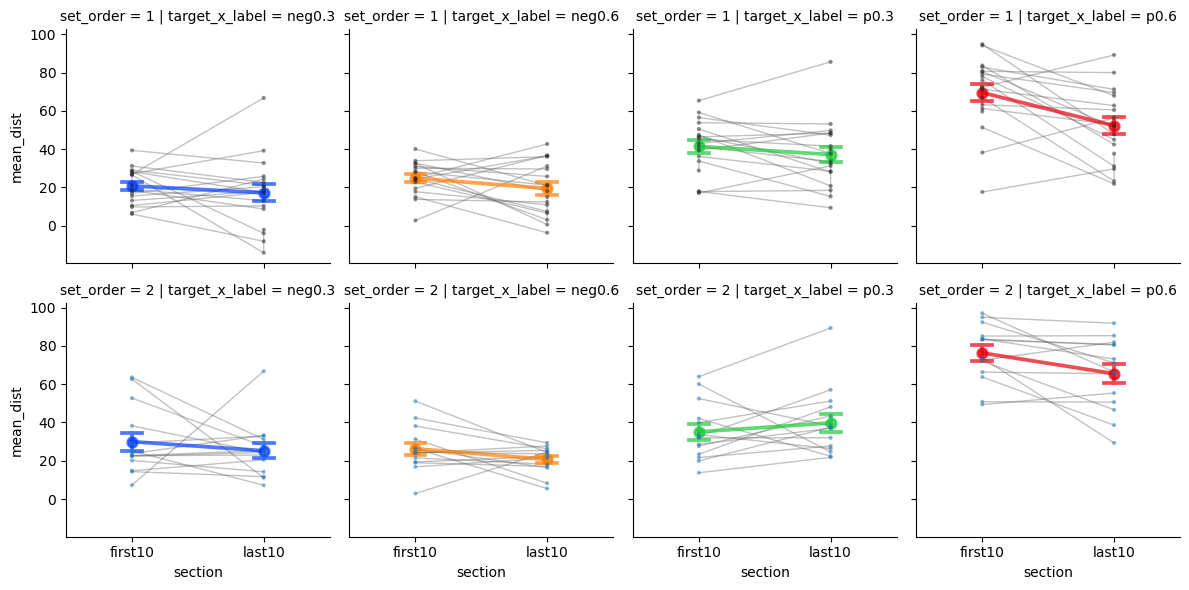

In [186]:
# first and last 10 trials of exposure
g = sns.FacetGrid(combined_10_means_filt, col = 'target_x_label', row='set_order')

# individual participant data points
g.map_dataframe(sns.stripplot,
                x='section', y='mean_dist',
                order=['first10','last10'],
                hue='set_order',
                jitter=0.0, alpha=0.5, size=3, linewidth=0
               )
# individual participant lines
g.map_dataframe(sns.lineplot,
                x='section', y='mean_dist',
                units='ppid', estimator=None, color='0.4',
                alpha=0.4, linewidth=1
               )

# mean line and se bands
g.map_dataframe(sns.pointplot,
                x='section', y='mean_dist',
                order=['first10','last10'],
                hue='target_x_label', palette='bright', alpha = 0.7,
                estimator=np.mean, errorbar='se', capsize=.15
               )

# Save and display
plt.savefig("first10_last10_exposure_filt.pdf", dpi=300, bbox_inches="tight")
plt.show()

C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*pl

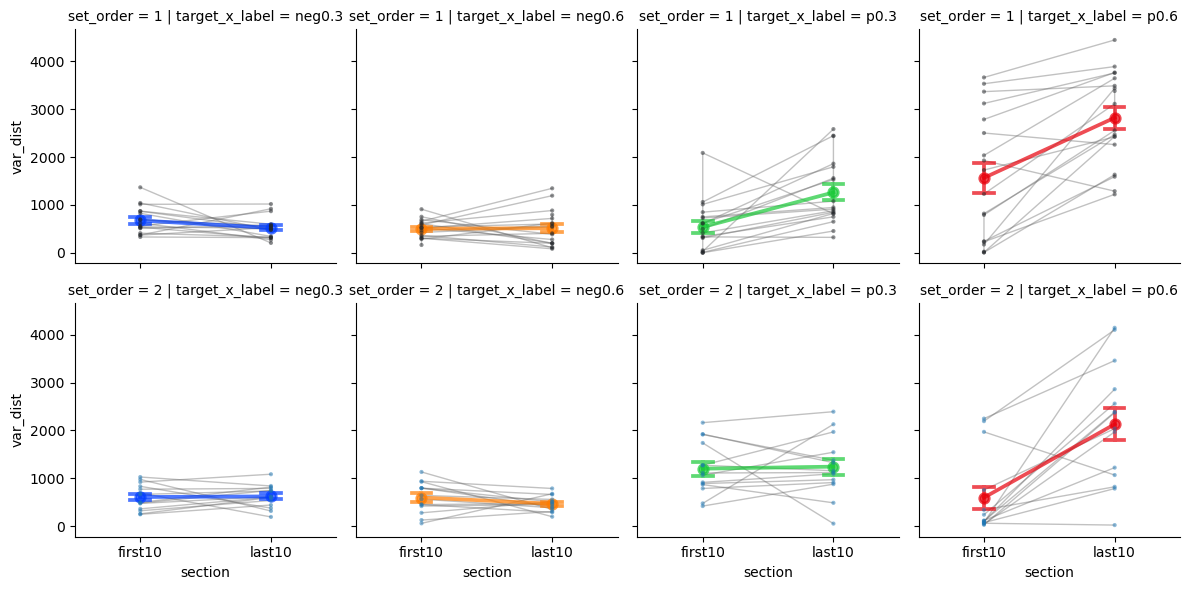

In [198]:
# first and last 10 trials variance of exposure
g = sns.FacetGrid(combined_10_means, col = 'target_x_label', row='set_order')

# individual participant data points
g.map_dataframe(sns.stripplot,
                x='section', y='var_dist',
                order=['first10','last10'],
                hue='set_order',
                jitter=0.0, alpha=0.5, size=3, linewidth=0
               )
# individual participant lines
g.map_dataframe(sns.lineplot,
                x='section', y='var_dist',
                units='ppid', estimator=None, color='0.4',
                alpha=0.4, linewidth=1
               )

# mean line and se bands
g.map_dataframe(sns.pointplot,
                x='section', y='var_dist',
                order=['first10','last10'],
                hue='target_x_label', palette='bright', alpha = 0.7,
                estimator=np.mean, errorbar='se', capsize=.15
               )

# Save and display
plt.savefig("first10_last10_exposure_var.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [188]:

combined_10_means_train = first10_last10_means_exp(df_small, min_b1=53, max_b1=202, min_b2=275, max_b2=424, error_col='baseline_corrected_dist', include_status=True)

combined_10_means_train = combined_10_means_train[combined_10_means_train['training_status'] == 'trained']

ppid  target_x_label  block
p000  neg0.3          2        75
      neg0.6          1        75
      p0.3            1        75
      p0.6            2        75
p002  neg0.3          1        75
                               ..
p036  p0.6            2        75
p037  neg0.3          1        75
      neg0.6          2        75
      p0.3            2        75
      p0.6            1        75
Length: 128, dtype: int64


C:\Users\jacob\AppData\Local\Temp\ipykernel_10364\3210746821.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['ppid','target_x_label','block'], group_keys=False))
C:\Users\jacob\AppData\Local\Temp\ipykernel_10364\3210746821.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  assert (df_aov.groupby(groupby_cols).size().max()) == 1, " >1 row per subject×cell"


C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*pl

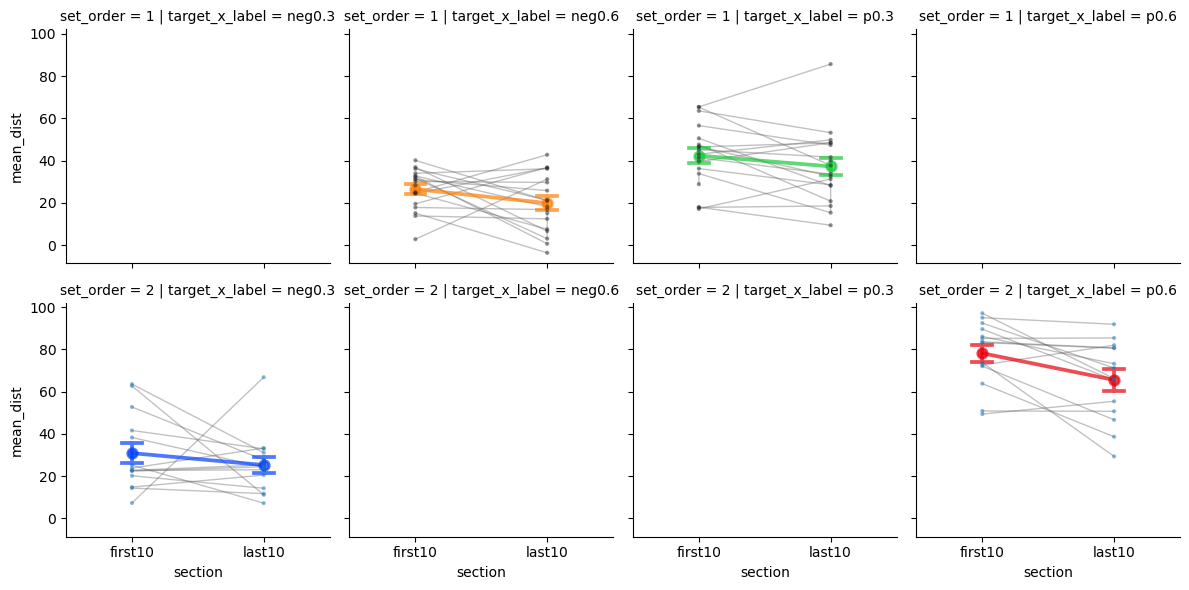

In [190]:
# first and last 10 trials of exposure (training ONLY)

g = sns.FacetGrid(combined_10_means_train, col = 'target_x_label', row='set_order')

# individual participant data points
g.map_dataframe(sns.stripplot,
                x='section', y='mean_dist',
                order=['first10','last10'],
                hue='set_order',
                jitter=0.0, alpha=0.5, size=3, linewidth=0
               )
# individual participant lines
g.map_dataframe(sns.lineplot,
                x='section', y='mean_dist',
                units='ppid', estimator=None, color='0.4',
                alpha=0.4, linewidth=1
               )

# mean line and se bands
g.map_dataframe(sns.pointplot,
                x='section', y='mean_dist',
                order=['first10','last10'],
                hue='target_x_label', palette='bright', alpha = 0.7,
                estimator=np.mean, errorbar='se', capsize=.15
               )

# Save and display
plt.savefig("first10_last10_exposure_train.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [644]:
# make df using the trained only dataset
combined_10_means_train.to_csv('exposure_F10_L10.csv', index=False)  


In [646]:

combined_10_means_transfer = first10_last10_means_exp(df_small, min_b1=53, max_b1=202, min_b2=275, max_b2=424, error_col='baseline_corrected_dist', include_status=True)

combined_10_means_transfer = combined_10_means_transfer[combined_10_means_transfer['training_status'] == 'transfer']

combined_10_means_transfer

C:\Users\jacob\AppData\Local\Temp\ipykernel_16412\4276120616.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['ppid','target_x_label','block'], group_keys=False))
C:\Users\jacob\AppData\Local\Temp\ipykernel_16412\4276120616.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  assert (df_aov.groupby(groupby_cols).size().max()) == 1, "Still >1 row per subject×cell"


ppid  section target_x_label set_order training_status  mean_dist
0    p000  first10         neg0.3         1        transfer  36.274896
3    p000  first10           p0.6         1        transfer  78.579978
4    p000   last10         neg0.3         1        transfer  -4.044592
7    p000   last10           p0.6         1        transfer  33.382702
9    p002  first10         neg0.6         2        transfer  27.916817
..    ...      ...            ...       ...             ...        ...
239  p036   last10           p0.6         1        transfer  64.166043
241  p037  first10         neg0.6         2        transfer  40.463232
242  p037  first10           p0.3         2        transfer  33.614927
245  p037   last10         neg0.6         2        transfer  11.827436
246  p037   last10           p0.3         2        transfer  33.638291

[124 rows x 6 columns]

C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#4c72b0'` for the same effect.

  func(*pl

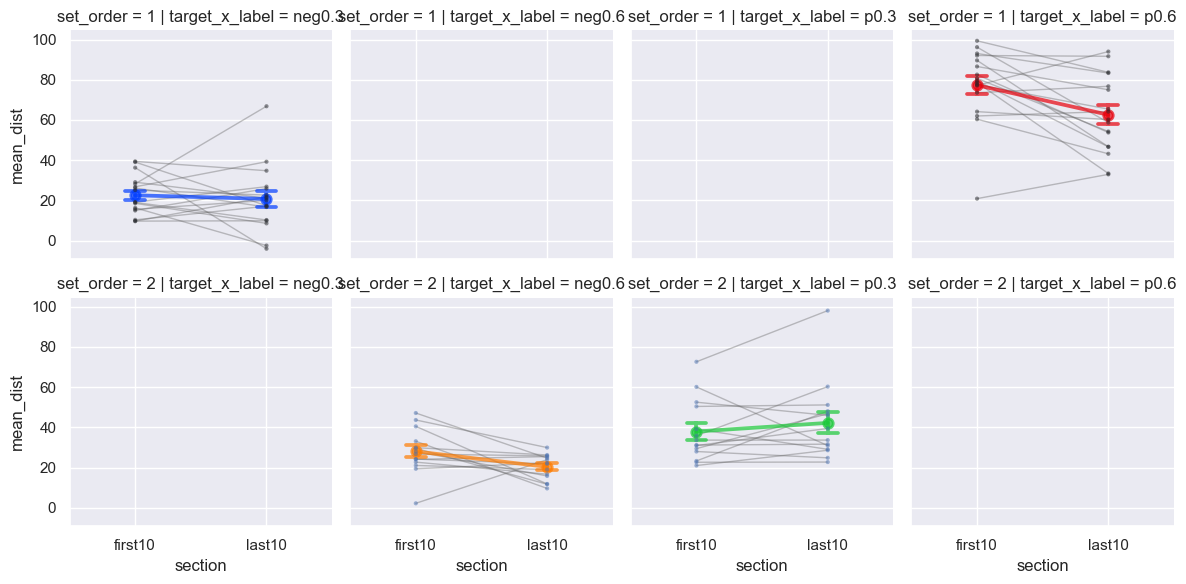

In [648]:
# first and last 10 trials of exposure (transfer ONLY)

g = sns.FacetGrid(combined_10_means_transfer, col = 'target_x_label', row='set_order')

# individual participant data points
g.map_dataframe(sns.stripplot,
                x='section', y='mean_dist',
                order=['first10','last10'],
                hue='set_order',
                jitter=0.0, alpha=0.5, size=3, linewidth=0
               )
# individual participant lines
g.map_dataframe(sns.lineplot,
                x='section', y='mean_dist',
                units='ppid', estimator=None, color='0.4',
                alpha=0.4, linewidth=1
               )

# mean line and se bands
g.map_dataframe(sns.pointplot,
                x='section', y='mean_dist',
                order=['first10','last10'],
                hue='target_x_label', palette='bright', alpha = 0.7,
                estimator=np.mean, errorbar='se', capsize=.15
               )

# Save and display
plt.savefig("first10_last10_exposure_transfer.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [192]:
# ANOVA libraries
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# fit ANOVA
aovrm = AnovaRM(combined_10_means, 'mean_dist', 'ppid', within=['section','target_x_label'])
results = aovrm.fit()
print(results)

ValueError: The data set contains more than one observation per subject and cell. Either aggregate the data manually, or pass the `aggregate_func` parameter.

In [258]:
# mixed model (full data)
m = smf.mixedlm("mean_dist ~ section * target_x_label + set_order",
                combined_10_means,
                groups=combined_10_means["ppid"])
print(m.fit().summary())


fit = m.fit()

                         Mixed Linear Model Regression Results
Model:                       MixedLM           Dependent Variable:           mean_dist 
No. Observations:            256               Method:                       REML      
No. Groups:                  31                Scale:                        211.2851  
Min. group size:             8                 Log-Likelihood:               -1042.1819
Max. group size:             16                Converged:                    Yes       
Mean group size:             8.3                                                       
---------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------------------
Intercept                                   23.839    3.150  7.567 0.000  17.664 30.014
section[T.last10]                           -4.105    3.6

In [260]:
# mixed model (filtered data)
m = smf.mixedlm("mean_dist ~ section * target_x_label + set_order",
                combined_10_means_filt,
                groups=combined_10_means_filt["ppid"])
print(m.fit().summary())


fit = m.fit()

                         Mixed Linear Model Regression Results
Model:                       MixedLM           Dependent Variable:           mean_dist 
No. Observations:            256               Method:                       REML      
No. Groups:                  31                Scale:                        202.7750  
Min. group size:             8                 Log-Likelihood:               -1037.4115
Max. group size:             16                Converged:                    Yes       
Mean group size:             8.3                                                       
---------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------------------
Intercept                                   23.510    3.100  7.583 0.000  17.434 29.587
section[T.last10]                           -4.093    3.5

In [940]:

# Predicted means from the fitted model
pred = fit.predict(combined_10_means)

combined_10_means['pred'] = pred

means = (combined_10_means
         .groupby(['section','target_x_label'])['pred']
         .mean()
         .reset_index())

print(means)


   section target_x_label       pred
0  first10         neg0.3  25.506051
1  first10         neg0.6  26.571110
2  first10           p0.3  39.440587
3  first10           p0.6  73.590584
4   last10         neg0.3  21.181883
5   last10         neg0.6  20.521999
6   last10           p0.3  38.593340
7   last10           p0.6  58.318239


C:\Users\jacob\AppData\Local\Temp\ipykernel_16412\4069536330.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['section','target_x_label'])['pred']


In [49]:
# trial by trial changes per target

def all_trials_exp(df, min_b1, max_b1, min_b2, max_b2):
    
    # filter exposure trials only
    exp = df[df['trial_num'].between(min_b1,max_b1) | (df['trial_num'].between(min_b2,max_b2))]

    # add block to indicate exposure to target sets
    exp['block'] = np.where(exp['trial_num'] <= max_b1, 1, 2)

    # order within each (ppid, target) by trial_num_target
    exp = exp.sort_values(['ppid', 'target_x_label', 'block', 'trial_num'])

    # counter per participant x target and block across exposure trials
    exp['exposure_trial_target'] = exp.groupby(['ppid', 'target_x_label', 'block']).cumcount() + 1
    return exp

# make exposure phase df using function
exposure_trials = all_trials_exp(df_small, min_b1=53, max_b1=202, min_b2=275, max_b2=424)

# show
display(exposure_trials)
exposure_trials.describe()

# 110.31
# 32.64
# 40.74

C:\Users\jacob\AppData\Local\Temp\ipykernel_10364\2487416347.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp['block'] = np.where(exp['trial_num'] <= max_b1, 1, 2)
C:\Users\jacob\AppData\Local\Temp\ipykernel_10364\2487416347.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  exp['exposure_trial_target'] = exp.groupby(['ppid', 'target_x_label', 'block']).cumcount() + 1


ppid  trial_num  trial_num_target  launch_deviation  launch_Speed  \
274    p000        276                14        -12.491517      4.960846   
275    p000        277                15          6.042343      3.860940   
278    p000        280                16         -4.430297      3.594671   
280    p000        282                17         -0.615157      4.087150   
281    p000        283                18        -16.968337      4.325164   
...     ...        ...               ...               ...           ...   
15553  p037        194                84         -9.226599      3.032560   
15555  p037        196                85        -10.973779      3.317465   
15557  p037        198                86        -12.669479      3.384499   
15558  p037        199                87        -10.871449      3.077932   
15561  p037        202                88        -12.179569      3.340399   

       ball_dist_to_center_cm target_hit  water_speed_binary  water_speed_m_s  \
274                110.319272      False                   1               -2   
275                 32.642498      False                   1               -2   
278                 40.741188      False                   1               -2   
280                 37.056480      False                   1               -2   
281                111.099408      False                   1               -2   
...                       ...        ...                 ...              ...   
15553              123.811292      False                   1               -2   
15555                7.417191       True                   1               -2   
15557                6.108336       True                   1               -2   
15558              124.710044      False                   1               -2   
15561                7.295278       True                   1               -2   

      target_x_label  ... hit_state error_x_plane error_z_plane  \
274           neg0.3  ...         0      0.186037      0.592435   
275           neg0.3  ...         0     -0.305593     -0.639516   
278           neg0.3  ...         0     -0.127967     -0.244226   
280           neg0.3  ...         0     -0.176041     -0.370996   
281           neg0.3  ...         0      0.257138      0.706965   
...              ...  ...       ...           ...           ...   
15553           p0.6  ...         0     -0.190858     -0.236871   
15555           p0.6  ...         1     -0.067857     -0.108503   
15557           p0.6  ...         1     -0.014213     -0.101358   
15558           p0.6  ...         0     -0.142142     -0.202621   
15561           p0.6  ...         1     -0.034598     -0.091872   

      baseline_dist_cm baseline_error_x  hit_rate  baseline_corrected_dist  \
274          17.120485         0.121472  0.384615                93.198787   
275          17.120485         0.121472  0.384615                15.522013   
278          17.120485         0.121472  0.384615                23.620703   
280          17.120485         0.121472  0.384615                19.935996   
281          17.120485         0.121472  0.384615                93.978923   
...                ...              ...       ...                      ...   
15553        12.044657         0.061008  0.307692               111.766635   
15555        12.044657         0.061008  0.307692                -4.627466   
15557        12.044657         0.061008  0.307692                -5.936321   
15558        12.044657         0.061008  0.307692               112.665387   
15561        12.044657         0.061008  0.307692                -4.749379   

       baseline_corrected_x  block  exposure_trial_target  
274                0.064565      2                      1  
275               -0.427065      2                      2  
278               -0.249439      2                      3  
280               -0.297513      2                      4  
281                0.135666      2                      5  
...                

trial_num  trial_num_target  launch_deviation  launch_Speed  \
count  9597.000000       9597.000000       9597.000000   9597.000000   
mean    238.511097         54.825570        -30.993243      2.541276   
std     119.153357         30.506981         20.332967      0.601746   
min      53.000000         13.000000       -108.175267      0.508496   
25%     128.000000         33.000000        -42.120377      2.140240   
50%     275.000000         52.000000        -27.111339      2.457769   
75%     350.000000         72.000000        -15.641129      2.858779   
max     424.000000        212.000000         99.619757      6.772579   

       ball_dist_to_center_cm  water_speed_binary  water_speed_m_s  \
count             9597.000000              9597.0           9597.0   
mean                51.683730                 1.0             -2.0   
std                 38.378485                 0.0              0.0   
min                  0.497909                 1.0             -2.0   
25%                  7.577086                 1.0             -2.0   
50%                 50.841208                 1.0             -2.0   
75%                 82.191320                 1.0             -2.0   
max                155.950086                 1.0             -2.0   

       target_position_x  target_position_z    hit_state  error_x_plane  \
count       9.597000e+03       9.597000e+03  9597.000000    9597.000000   
mean        8.144181e-18       1.400000e+00     0.308534      -0.030271   
std         4.743812e-01       2.331590e-13     0.461912       0.355453   
min        -6.000000e-01       1.400000e+00     0.000000      -0.932212   
25%        -6.000000e-01       1.400000e+00     0.000000      -0.274037   
50%         3.000000e-01       1.400000e+00     0.000000       0.004803   
75%         3.000000e-01       1.400000e+00     1.000000       0.144718   
max         6.000000e-01       1.400000e+00     1.000000       1.574061   

       error_z_plane  baseline_dist_cm  baseline_error_x     hit_rate  \
count    9597.000000       9597.000000       9597.000000  9597.000000   
mean       -0.240213         16.308899          0.074392     0.455709   
std         0.449059          6.651228          0.079707     0.206843   
min        -1.400000          7.339201         -0.082652     0.076923   
25%        -0.544023         10.976919          0.010904     0.307692   
50%        -0.182592         14.788648          0.063225     0.461538   
75%         0.050607         20.366142          0.127439     0.615385   
max         1.069499         39.054821          0.308704     0.923077   

       baseline_corrected_dist  baseline_corrected_x        block  \
count              9597.000000           9597.000000  9597.000000   
mean                 35.374832             -0.104663     1.500052   
std                  38.620115              0.371331     0.500026   
min                 -36.749386             -1.132368     1.000000   
25%                  -3.584944             -0.338291     1.000000   
50%                  33.143572             -0.093458     2.000000   
75%                  65.761667              0.095758     2.000000   
max                 140.822455              1.521808     2.000000   

       exposure_trial_target  
count            9597.000000  
mean               37.988434  
std                21.643334  
min                 1.000000  
25%                19.000000  
50%                38.000000  
75%                57.000000  
max                75.000000

C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

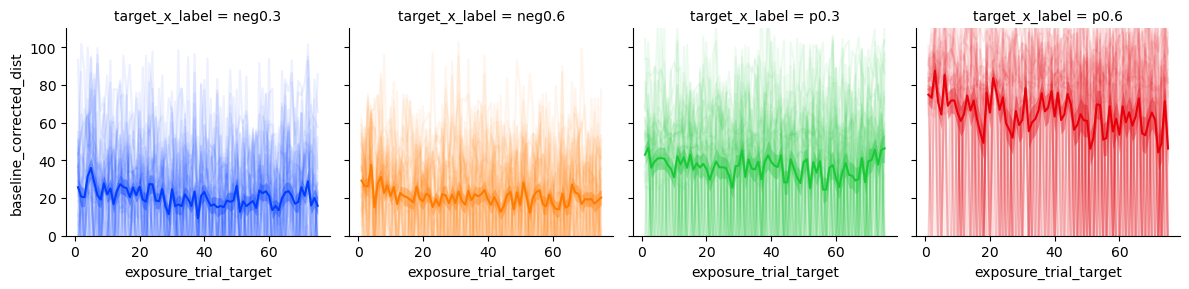

In [51]:
# set facets by target
g = sns.FacetGrid(exposure_trials, col='target_x_label', sharex=True, sharey=True)
# set Y lim to 110.0 cm
g.set(ylim=(None, 110.0))

# individual data
g.map_dataframe(sns.lineplot,
                x='exposure_trial_target', y='baseline_corrected_dist',
                estimator=None, units='ppid',
                hue = 'target_x_label', palette='bright',
                alpha=0.075)
# mean line and se bands
g.map_dataframe(sns.lineplot,
                x='exposure_trial_target', y='baseline_corrected_dist',
                estimator='mean', errorbar='se', err_kws={'alpha':0.35, 'linewidth':0},
                hue = 'target_x_label', palette='bright', alpha=1)

# Save and display
plt.savefig("all_trials_exp_per_target.pdf", dpi=300, bbox_inches="tight")
plt.show()

C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

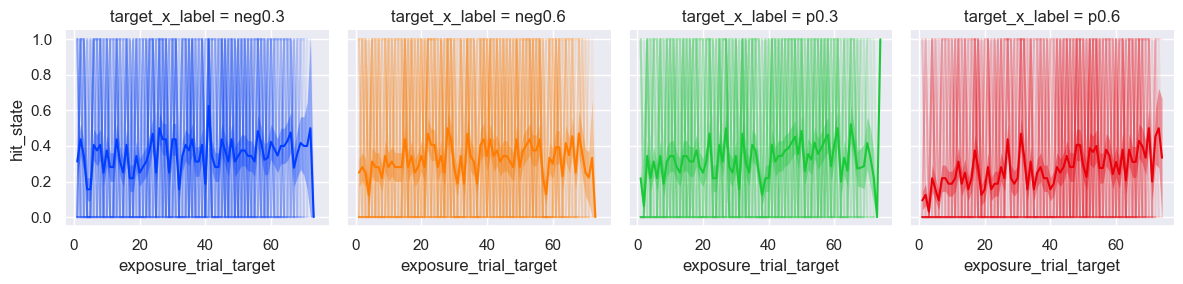

In [660]:
# set facets by target
g = sns.FacetGrid(exposure_trials, col='target_x_label', sharex=True, sharey=True)
# set Y lim to 110.0 cm
#g.set(ylim=(None, 110.0))

# individual data
g.map_dataframe(sns.lineplot,
                x='exposure_trial_target', y='hit_state',
                estimator=None, units='ppid',
                hue = 'target_x_label', palette='bright',
                alpha=0.075)
# mean line and se bands
g.map_dataframe(sns.lineplot,
                x='exposure_trial_target', y='hit_state',
                estimator='mean', errorbar='se', err_kws={'alpha':0.35, 'linewidth':0},
                hue = 'target_x_label', palette='bright', alpha=1)

# Save and display
plt.savefig("all_trials_exp_per_target.pdf", dpi=300, bbox_inches="tight")
plt.show()

C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

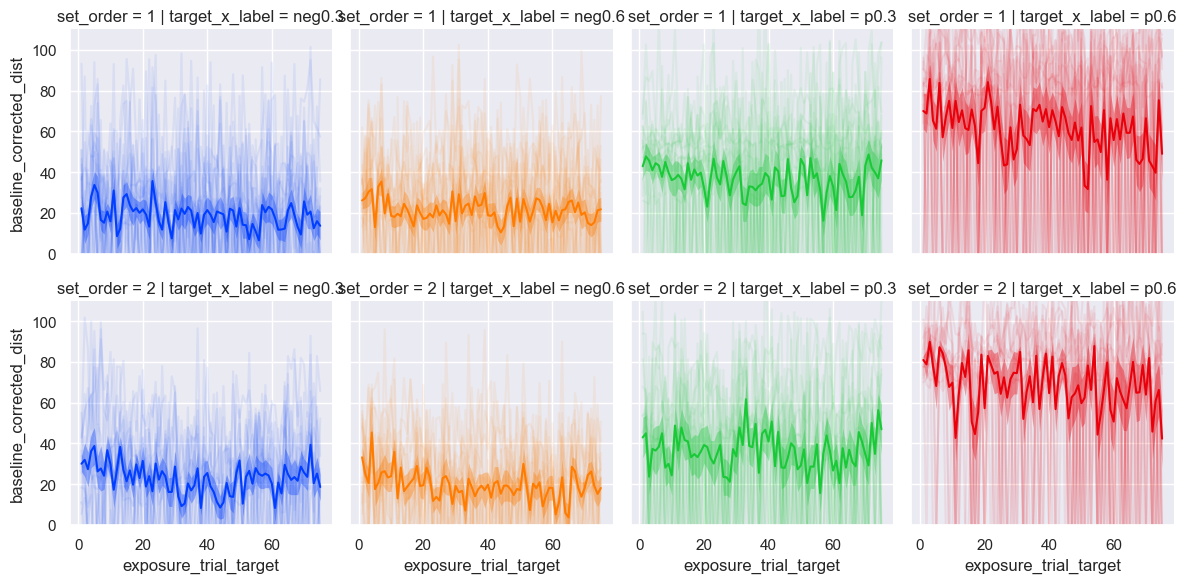

In [924]:
# lineplot: error across trials (including facet with set_order)

# set facets by target
g = sns.FacetGrid(exposure_trials, col='target_x_label', row='set_order', sharex=True, sharey=True)
# set Y lim to 110.0 cm
g.set(ylim=(None, 110.0))

# individual data
g.map_dataframe(sns.lineplot,
                x='exposure_trial_target', y='baseline_corrected_dist',
                estimator=None, units='ppid',
                hue = 'target_x_label', palette='bright',
                alpha=0.075)
# mean line and se bands
g.map_dataframe(sns.lineplot,
                x='exposure_trial_target', y='baseline_corrected_dist',
                estimator='mean', errorbar='se', err_kws={'alpha':0.35, 'linewidth':0},
                hue = 'target_x_label', palette='bright', alpha=1)

# Save and display
plt.savefig("all_trials_exp_per_target_by_sets_mean_dist.pdf", dpi=300, bbox_inches="tight")
plt.show()


C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

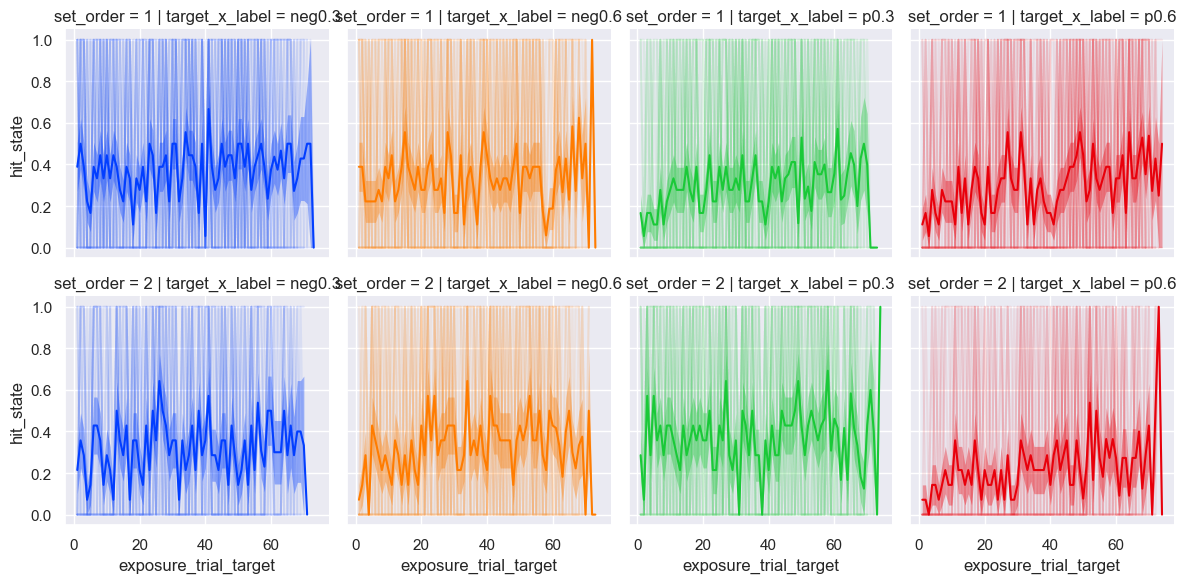

In [664]:
# lineplot: hits across trials (including facet with set_order)

# set facets by target
g = sns.FacetGrid(exposure_trials, col='target_x_label', row='set_order', sharex=True, sharey=True)
# set Y lim to 110.0 cm
#g.set(ylim=(None, 110.0))

# individual data
g.map_dataframe(sns.lineplot,
                x='exposure_trial_target', y='hit_state',
                estimator=None, units='ppid',
                hue = 'target_x_label', palette='bright',
                alpha=0.075)
# mean line and se bands
g.map_dataframe(sns.lineplot,
                x='exposure_trial_target', y='hit_state',
                estimator='mean', errorbar='se', err_kws={'alpha':0.35, 'linewidth':0},
                hue = 'target_x_label', palette='bright', alpha=1)

# Save and display
plt.savefig("all_trials_exp_per_target_by_sets_hits.pdf", dpi=300, bbox_inches="tight")
plt.show()


C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

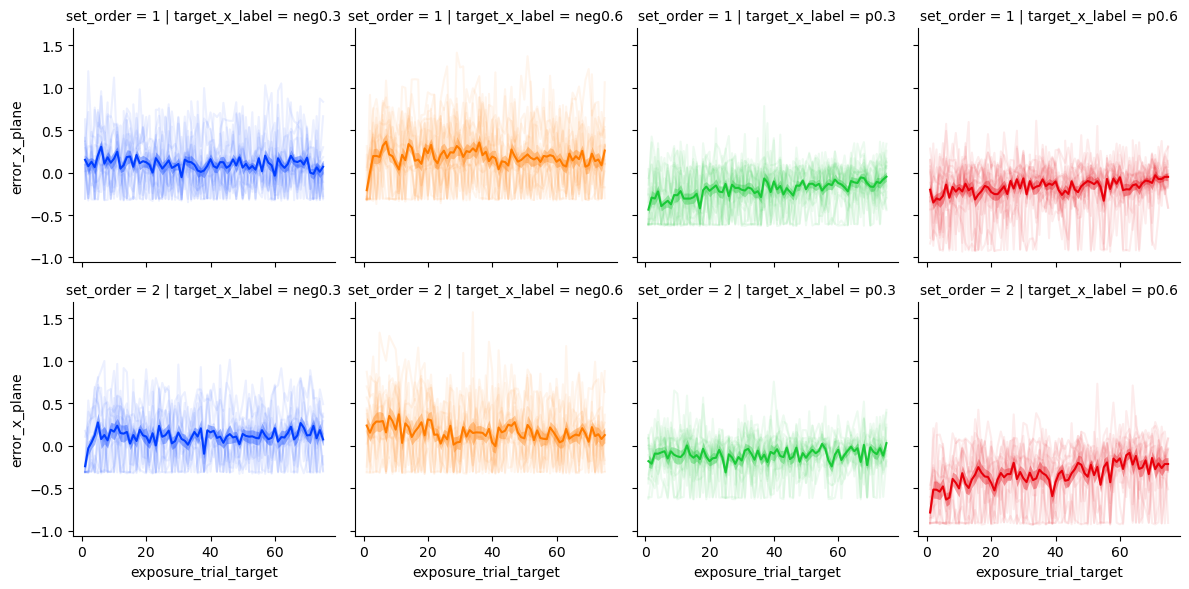

In [267]:
#error_x_plane


# lineplot: error across trials (including facet with set_order)

# set facets by target
g = sns.FacetGrid(exposure_trials, col='target_x_label', row='set_order', sharex=True, sharey=True)
# set Y lim to 110.0 cm
#g.set(ylim=(None, 1.00))

# individual data
g.map_dataframe(sns.lineplot,
                x='exposure_trial_target', y='error_x_plane',
                estimator=None, units='ppid',
                hue = 'target_x_label', palette='bright',
                alpha=0.075)
# mean line and se bands
g.map_dataframe(sns.lineplot,
                x='exposure_trial_target', y='error_x_plane',
                estimator='mean', errorbar='se', err_kws={'alpha':0.35, 'linewidth':0},
                hue = 'target_x_label', palette='bright', alpha=1)

# Save and display
plt.savefig("all_trials_exp_per_target_by_sets_error_x_plane.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [53]:

# generalization
# need to grab the first 10 trials per participant per target (we can filter out the exposure 
# label the ppid who experienced each target first and second (block 1 and block 2)

# filter so we only have first 10 trials

combined_10_means_gen = first10_last10_means_exp(df_small, min_b1=53, max_b1=202, min_b2=275, max_b2=424, 
                                                 error_col='baseline_corrected_dist', include_status=True)


gen_exposure = combined_10_means_gen[combined_10_means_gen['section'] == 'first10']
gen_exposure



gen_exposure.head(8)

ppid  target_x_label  block
p000  neg0.3          2        75
      neg0.6          1        75
      p0.3            1        75
      p0.6            2        75
p002  neg0.3          1        75
                               ..
p036  p0.6            2        75
p037  neg0.3          1        75
      neg0.6          2        75
      p0.3            2        75
      p0.6            1        75
Length: 128, dtype: int64


C:\Users\jacob\AppData\Local\Temp\ipykernel_10364\3210746821.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['ppid','target_x_label','block'], group_keys=False))
C:\Users\jacob\AppData\Local\Temp\ipykernel_10364\3210746821.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  assert (df_aov.groupby(groupby_cols).size().max()) == 1, " >1 row per subject×cell"


ppid  section target_x_label set_order  block training_status  mean_dist  \
0   p000  first10         neg0.3         1      2        transfer  28.393533   
1   p000  first10         neg0.6         1      1         trained  36.870157   
2   p000  first10           p0.3         1      1         trained  50.520079   
3   p000  first10           p0.6         1      2        transfer  76.090083   
8   p002  first10         neg0.3         2      1         trained  22.629865   
9   p002  first10         neg0.6         2      2        transfer  26.255505   
10  p002  first10           p0.3         2      2        transfer  31.947954   
11  p002  first10           p0.6         2      1         trained  86.068936   

       var_dist   n  
0   1368.492609  10  
1    753.769148  10  
2     30.536705  10  
3   3533.883662  10  
8    246.364413  10  
9    277.766951  10  
10   889.660576  10  
11    72.692162  10

In [55]:
max_tbl = (gen_exposure
           .groupby(['target_x_label','training_status','set_order'], dropna=False)['mean_dist']
           .max()
           .reset_index(name='max_mean_dist'))
max_tbl

C:\Users\jacob\AppData\Local\Temp\ipykernel_10364\1565530399.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['target_x_label','training_status','set_order'], dropna=False)['mean_dist']


target_x_label training_status set_order  max_mean_dist
0          neg0.3         trained         1            NaN
1          neg0.3         trained         2      63.564382
2          neg0.3        transfer         1      39.385336
3          neg0.3        transfer         2            NaN
4          neg0.6         trained         1      40.096858
5          neg0.6         trained         2            NaN
6          neg0.6        transfer         1            NaN
7          neg0.6        transfer         2      49.519244
8            p0.3         trained         1      65.380975
9            p0.3         trained         2            NaN
10           p0.3        transfer         1            NaN
11           p0.3        transfer         2      63.953100
12           p0.6         trained         1            NaN
13           p0.6         trained         2      97.083308
14           p0.6        transfer         1      94.904650
15           p0.6        transfer         2            NaN

In [209]:
gen_exposure

gen_exposure.to_csv('gen_exposure_f10.csv', index=False)  


C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*pl

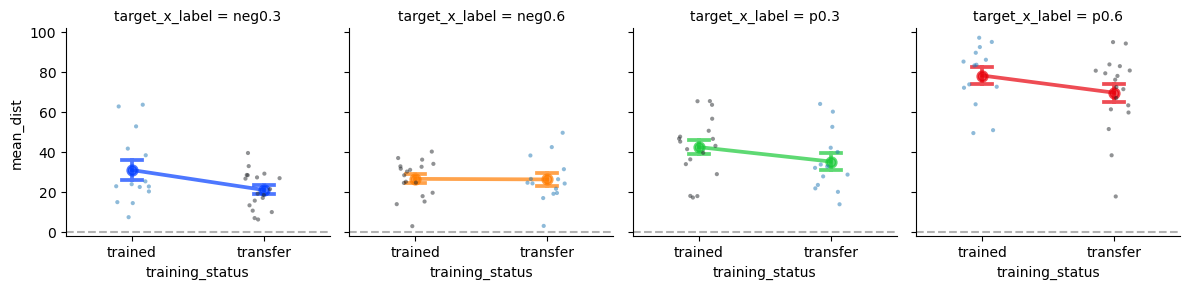

In [57]:
# set facets by target
g = sns.FacetGrid(gen_exposure, col='target_x_label', sharex=True, sharey=True)

#sns.set_palette("bright")



# individual data
g.map_dataframe(sns.stripplot,
                x='training_status', y='mean_dist',
                order=['trained','transfer'],
                hue='set_order',
                jitter=0.15, alpha=0.5, size=3, linewidth=0
)


# mean line and se bands
g.map_dataframe(sns.pointplot,
                x='training_status', y='mean_dist',
                order=['trained','transfer'],
                hue='target_x_label', palette='bright', alpha = 0.7,
                estimator=np.mean, errorbar='se', capsize=.15
)

# add horizontal line at error of 0 (update to show line at baseline)
for ax in g.axes.flat:
    ax.axhline(y=0.0, color = 'black', linestyle='--', alpha = 0.3)

plt.savefig("generalization_same_side_target.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [672]:
# 3) Sanity: numbers should match contrasts
print(gen_exposure.groupby(['target_x_label','training_status'])['mean_dist']
      .mean().unstack())

print(gen_exposure)

training_status    trained   transfer
target_x_label                       
neg0.3           28.633651  22.535295
neg0.6           23.536437  27.982220
p0.3             45.558197  37.878610
p0.6             77.826439  77.281303
     ppid  section target_x_label set_order training_status  mean_dist
0    p000  first10         neg0.3         1        transfer  36.274896
1    p000  first10         neg0.6         1         trained   7.594764
2    p000  first10           p0.3         1         trained  57.684222
3    p000  first10           p0.6         1        transfer  78.579978
8    p002  first10         neg0.3         2         trained   8.685021
..    ...      ...            ...       ...             ...        ...
235  p036  first10           p0.6         1        transfer  61.969196
240  p037  first10         neg0.3         2         trained  54.521609
241  p037  first10         neg0.6         2        transfer  40.463232
242  p037  first10           p0.3         2        transfer  3

C:\Users\jacob\AppData\Local\Temp\ipykernel_16412\653678896.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(gen_exposure.groupby(['target_x_label','training_status'])['mean_dist']


In [65]:
import statsmodels.formula.api as smf
mod_gen = smf.ols("mean_dist ~ C(training_status) * C(target_x_label) + C(set_order)",
                  data=gen_exposure).fit(
    cov_type="cluster", cov_kwds={"groups": gen_exposure["ppid"]}
)
print(mod_gen.summary())


                            OLS Regression Results                            
Dep. Variable:              mean_dist   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     214.2
Date:                Sat, 06 Sep 2025   Prob (F-statistic):           2.66e-24
Time:                        23:10:09   Log-Likelihood:                -520.00
No. Observations:                 128   AIC:                             1056.
Df Residuals:                     120   BIC:                             1079.
Df Model:                           7                                         
Covariance Type:              cluster                                         
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [791]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Mixed model with random intercepts for ppid
mod_gen2 = smf.mixedlm("mean_dist ~ target_x_label * training_status",
                gen_exposure, groups=gen_exposure["ppid"])
res = mod_gen2.fit(reml=True)

# Emmeans-like simple contrasts:
# Fit separate OLS per target, or compute marginal means by status within each target
out = []
for t in gen_exposure['target_x_label'].unique():
    sub = gen_exposure[gen_exposure['target_x_label']==t]
    mod = smf.ols("mean_dist ~ C(training_status)", data=sub).fit()
    # Welch t-test equivalent:
    import scipy.stats as st
    g = [sub.loc[sub.training_status==lvl, "mean_dist"].values for lvl in ["trained","transfer"]]
    tstat, p = st.ttest_ind(g[0], g[1], equal_var=False)
    out.append((t, tstat, p, g[0].mean()-g[1].mean(), len(g[0]), len(g[1])))
out


C:\Users\jacob\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jacob\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


[('neg0.3', 1.877171945923877, 0.07631879083265619, 9.967464928323068, 14, 18),
 ('neg0.6',
  0.0718288065309063,
  0.9433063156291358,
  0.2749977089100071,
  18,
  14),
 ('p0.3', 1.3390398463094701, 0.1912117568041085, 7.238745156348244, 18, 14),
 ('p0.6', 1.4084440409608736, 0.1692854713155979, 8.58943819434171, 14, 18)]

In [508]:
import bambi as bmb
import arviz as az

# --- model: logistic mixed, random intercept per subject ---
m = bmb.Model(
    "hit_state ~ training_status * target_x_label + (1|ppid)",
    data=first10_exp,
    family="bernoulli")

idata = m.fit(chains=4, draws=1000, tune=1200, target_accept=0.9, random_seed=7)

print(az.summary(idata, var_names=["Intercept",
                                   "training_status",
                                   "target_x_label",
                                   "training_status:target_x_label"])[
      ["mean","hdi_3%","hdi_97%","r_hat"]])


Modeling the probability that hit_state==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, training_status, target_x_label, training_status:target_x_label, 1|ppid_sigma, 1|ppid_offset]


Output()

Sampling 4 chains for 1_200 tune and 1_000 draw iterations (4_800 + 4_000 draws total) took 5132 seconds.


                                                   mean  hdi_3%  hdi_97%  \
Intercept                                        -1.541  -1.934   -1.153   
training_status[transfer]                         0.911   0.425    1.369   
target_x_label[neg0.6]                            0.166  -0.339    0.670   
target_x_label[p0.3]                             -0.289  -0.817    0.254   
target_x_label[p0.6]                             -0.884  -1.499   -0.223   
training_status:target_x_label[transfer, neg0.6] -0.816  -1.592   -0.103   
training_status:target_x_label[transfer, p0.3]    0.386  -0.331    1.114   
training_status:target_x_label[transfer, p0.6]    0.093  -0.649    0.802   

                                                  r_hat  
Intercept                                           1.0  
training_status[transfer]                           1.0  
target_x_label[neg0.6]                              1.0  
target_x_label[p0.3]                                1.0  
target_x_label[p0.6]     

In [500]:
def log_odd_convert(intercept, vals):

    vals = np.array(vals)

    total = intercept + vals
    
    p = np.exp(total) / (1 + np.exp(total))

    return(p)

log_odd_convert(intercept = -1.536, vals = [0.906])


array([0.17711751])

In [472]:
p = np.exp(1)**-1.536 / (1 + np.exp(1)**-1.536)
p

0.1771175096186845

In [504]:


# --- model: logistic mixed, random intercept per subject ---
m2 = bmb.Model(
    "hit_state ~ training_status + (1|ppid)",
    data=first10_exp,
    family="bernoulli",
    priors={"Common": bmb.Prior("Normal", mu=0, sigma=1)}  # mild regularization helps
)
idata = m2.fit(chains=4, draws=2000, target_accept=0.9)

print(az.summary(idata, var_names=["Intercept",
                                   "training_status"])[
      ["mean","hdi_3%","hdi_97%","r_hat"]])


Modeling the probability that hit_state==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, training_status, 1|ppid_sigma, 1|ppid_offset]


Output()

ValueError: Not enough samples to build a trace.

In [49]:

mod_gen_dist = ols('mean_dist ~ C(training_status) * C(target_x_label)', data = gen_exposure).fit()

anova_table = anova_lm(mod, type=2)
print(anova_table)

NameError: name 'anova_lm' is not defined

In [207]:
# mixed linear model

mod_gen2 = mixedlm('mean_dist ~ C(training_status) * C(target_x_label)', data=gen_exposure, groups=gen_exposure['ppid']).fit()

print(mod_gen2.summary())

C:\Users\jacob\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jacob\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jacob\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


                                 Mixed Linear Model Regression Results
Model:                            MixedLM                 Dependent Variable:                 mean_dist
No. Observations:                 124                     Method:                             REML     
No. Groups:                       31                      Scale:                              213.8556 
Min. group size:                  4                       Log-Likelihood:                     -487.3838
Max. group size:                  4                       Converged:                          No       
Mean group size:                  4.0                                                                  
-------------------------------------------------------------------------------------------------------
                                                            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------------------------------------------

C:\Users\jacob\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jacob\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\jacob\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1.311496
  warnings.warn(msg, ConvergenceWarning)


In [271]:
### For washout we need to extract trials between:
# 203 & 274 / 425 & 496

def all_trials_washout(df, min_b1, max_b1, min_b2, max_b2):
    
    # filter exposure trials only
    wash = df[df['trial_num'].between(min_b1,max_b1) | (df['trial_num'].between(min_b2,max_b2))]

    # add block to indicate exposure to target sets
    wash['block'] = np.where(wash['trial_num'] <= max_b1, 1, 2)

    # order within each (ppid, target) by trial_num_target
    wash = wash.sort_values(['ppid', 'target_x_label', 'block', 'trial_num'])

    # counter per participant x target and block across exposure trials
    wash['washout_trial_target'] = wash.groupby(['ppid', 'target_x_label', 'block']).cumcount() + 1
    return wash

# make exposure phase df using function
washout_trials = all_trials_washout(df_small, min_b1=203, max_b1=274, min_b2=425, max_b2=496)
washout_trials.head()



C:\Users\jacob\AppData\Local\Temp\ipykernel_29952\471622998.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wash['block'] = np.where(wash['trial_num'] <= max_b1, 1, 2)
C:\Users\jacob\AppData\Local\Temp\ipykernel_29952\471622998.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wash['washout_trial_target'] = wash.groupby(['ppid', 'target_x_label', 'block']).cumcount() + 1


ppid  trial_num  trial_num_target  launch_deviation  launch_Speed  \
423  p000        425                89        -11.642927      3.383015   
425  p000        427                90        -10.057857      3.220239   
427  p000        429                91         -3.524727      3.436478   
430  p000        432                92         -8.581447      2.638650   
432  p000        434                93         -0.633057      2.826992   

     ball_dist_to_center_cm target_hit  water_speed_binary  water_speed_m_s  \
423               29.082605      False                   0                0   
425               25.018275      False                   0                0   
427                9.091502      False                   0                0   
430               21.455958      False                   0                0   
432               31.898841      False                   1               -2   

    target_x_label  ... hit_state error_x_plane error_z_plane  \
423         neg0.3  ...         0      0.289099     -0.017702   
425         neg0.3  ...         0      0.251408     -0.033733   
427         neg0.3  ...         0      0.091608     -0.017181   
430         neg0.3  ...         0      0.214552     -0.008248   
432         neg0.3  ...         0     -0.308650     -0.527493   

    baseline_dist_cm baseline_error_x  hit_rate  baseline_corrected_dist  \
423        17.120485         0.121472  0.384615                11.962120   
425        17.120485         0.121472  0.384615                 7.897790   
427        17.120485         0.121472  0.384615                -8.028983   
430        17.120485         0.121472  0.384615                 4.335473   
432        17.120485         0.121472  0.384615                14.778357   

     baseline_corrected_x  block  washout_trial_target  
423              0.167627      2                     1  
425              0.129936      2                     2  
427             -0.029864      2                     3  
430              0.093080      2                     4  
432             -0.430122      2                     5  

[5 rows x 27 columns]

In [293]:
washout_trials[washout_trials.water_speed_binary.ne(washout_trials.water_speed_binary.shift())][[ 'trial_num','washout_trial_target','water_speed_binary',
                                                                                                'target_x_label']]

trial_num  washout_trial_target  water_speed_binary target_x_label
423          425                     1                   0         neg0.3
432          434                     5                   1         neg0.3
440          442                     9                   0         neg0.3
447          449                    13                   1         neg0.3
456          458                    17                   0         neg0.3
...          ...                   ...                 ...            ...
15594        235                    17                   0           p0.6
15602        243                    21                   1           p0.6
15610        251                    25                   0           p0.6
15619        260                    29                   1           p0.6
15627        268                    33                   0           p0.6

[1025 rows x 4 columns]

In [295]:
# washout trials ONLY still-water
washout_trials_still = washout_trials[washout_trials['water_speed_binary'] == 0]
washout_trials_still


ppid  trial_num  trial_num_target  launch_deviation  launch_Speed  \
423    p000        425                89        -11.642927      3.383015   
425    p000        427                90        -10.057857      3.220239   
427    p000        429                91         -3.524727      3.436478   
430    p000        432                92         -8.581447      2.638650   
440    p000        442                97         -7.258397      2.950399   
...     ...        ...               ...               ...           ...   
15617  p037        258               116          1.329851      2.238340   
15627  p037        268               121          1.386511      2.482665   
15628  p037        269               122         -3.500079      2.086529   
15630  p037        271               123          4.836881      2.614344   
15632  p037        273               124         -1.011779      2.362442   

       ball_dist_to_center_cm target_hit  water_speed_binary  water_speed_m_s  \
423                 29.082605      False                   0                0   
425                 25.018275      False                   0                0   
427                  9.091502      False                   0                0   
430                 21.455958      False                   0                0   
440                 18.091278      False                   0                0   
...                       ...        ...                 ...              ...   
15617                6.177456       True                   0                0   
15627                5.991099       True                   0                0   
15628                9.431813      False                   0                0   
15630               12.900636      False                   0                0   
15632                5.805935       True                   0                0   

      target_x_label  ... hit_state error_x_plane error_z_plane  \
423           neg0.3  ...         0      0.289099     -0.017702   
425           neg0.3  ...         0      0.251408     -0.033733   
427           neg0.3  ...         0      0.091608     -0.017181   
430           neg0.3  ...         0      0.214552     -0.008248   
440           neg0.3  ...         0      0.183963     -0.028588   
...              ...  ...       ...           ...           ...   
15617           p0.6  ...         1     -0.064448     -0.065671   
15627           p0.6  ...         1     -0.065888     -0.065443   
15628           p0.6  ...         0      0.076234     -0.200191   
15630           p0.6  ...         0     -0.138163     -0.008563   
15632           p0.6  ...         1     -0.011423     -0.090991   

      baseline_dist_cm baseline_error_x  hit_rate  baseline_corrected_dist  \
423          17.120485         0.121472  0.384615                11.962120   
425          17.120485         0.121472  0.384615                 7.897790   
427          17.120485         0.121472  0.384615                -8.028983   
430          17.120485         0.121472  0.384615                 4.335473   
440          17.120485         0.121472  0.384615                 0.970793   
...                ...              ...       ...                      ...   
15617        12.044657         0.061008  0.307692                -5.867201   
15627        12.044657         0.061008  0.307692                -6.053558   
15628        12.044657         0.061008  0.307692                -2.612844   
15630        12.044657         0.061008  0.307692                 0.855979   
15632        12.044657         0.061008  0.307692                -6.238722   

       baseline_corrected_x  block  washout_trial_target  
423                0.167627      2                     1  
425                0.129936      2                     2  
427               -0.029864      2                     3  
430                0.093080      2                     4  
440                0.062491      2                     9  
...                     .

In [561]:
# merge transition trial data
washout_transition = washout_trials[['trial_num','washout_trial_target','set_order','target_x_label']].drop_duplicates()

# make new df labeling the transition trials with the corresponding washout trials
transitions_x = (transition_trials.merge(washout_transition, 
                                        on=['trial_num','set_order','target_x_label'], how='left').dropna(subset=['washout_trial_target']))

transition_x = transition_trials.query('changed_state == 1 and water_speed_binary == 1').merge(washout_transition,
                                                                                        on='trial_num')['washout_trial_target']

print(transitions_x.head())


AttributeError: 'function' object has no attribute 'merge'

C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

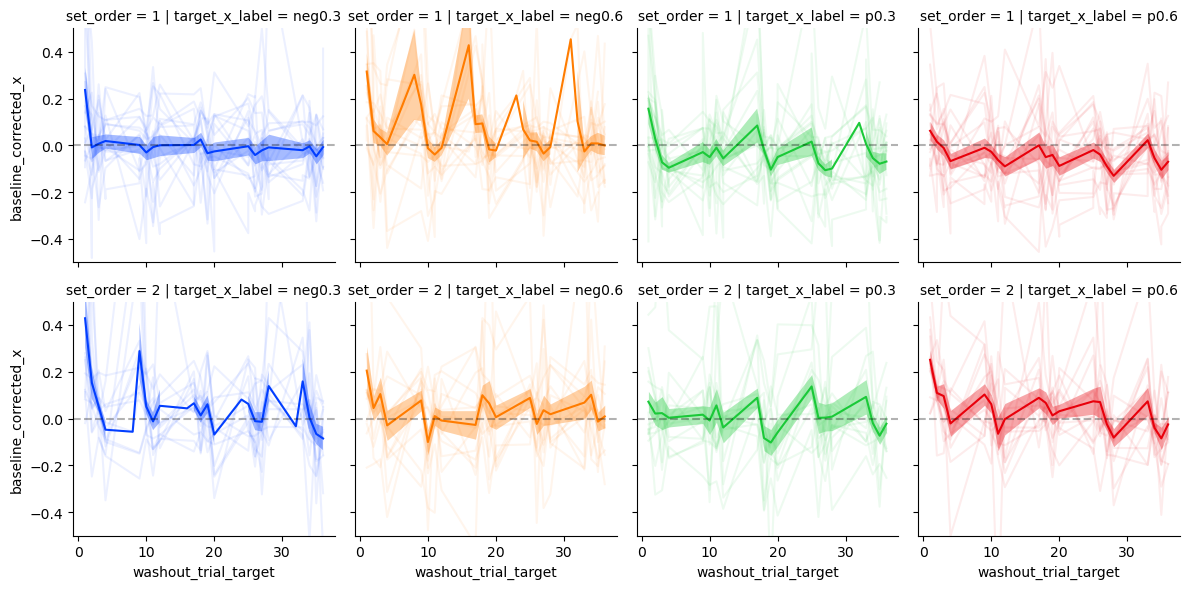

In [299]:

# set facets by target
g = sns.FacetGrid(washout_trials_still, col='target_x_label', row='set_order', sharex=True, sharey=True)
# set Y lim
g.set(ylim=(-0.5, 0.5))


# individual data
g.map_dataframe(sns.lineplot,
                x='washout_trial_target', y='baseline_corrected_x',
                estimator=None, units='ppid',
                hue = 'target_x_label', palette='bright',
                alpha=0.075)
# mean line and se bands
g.map_dataframe(sns.lineplot,
                x='washout_trial_target', y='baseline_corrected_x',
                estimator='mean', errorbar='se', err_kws={'alpha':0.35, 'linewidth':0},
                hue = 'target_x_label', palette='bright', alpha=1, style = 'water_speed_binary')

# add horizontal line at error of 0
for ax in g.axes.flat:
    ax.axhline(y=0.0, color = 'black', linestyle='--', alpha = 0.3)

# Save and display
plt.savefig("test.pdf", dpi=300, bbox_inches="tight")
plt.show()


C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

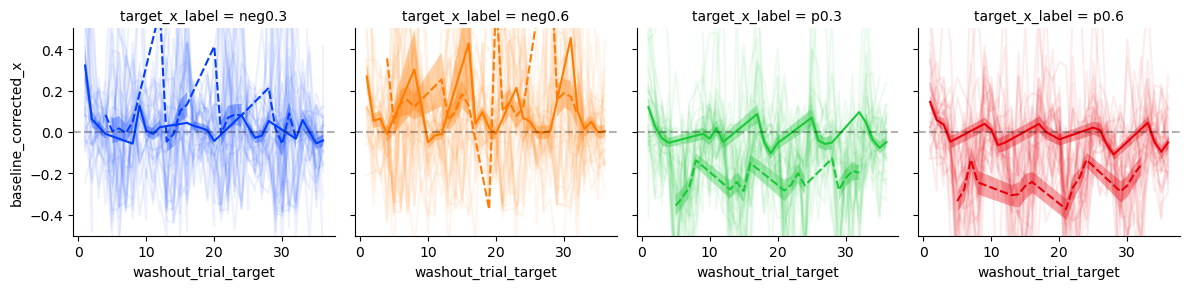

In [61]:

# set facets by target
g = sns.FacetGrid(washout_trials, col='target_x_label', sharex=True, sharey=True)
# set Y lim
g.set(ylim=(-0.5, 0.5))


# individual data
g.map_dataframe(sns.lineplot,
                x='washout_trial_target', y='baseline_corrected_x',
                estimator=None, units='ppid',
                hue = 'target_x_label', palette='bright',
                alpha=0.075)
# mean line and se bands
g.map_dataframe(sns.lineplot,
                x='washout_trial_target', y='baseline_corrected_x',
                estimator='mean', errorbar='se', err_kws={'alpha':0.35, 'linewidth':0},
                hue = 'target_x_label', palette='bright', alpha=1, style = 'water_speed_binary')




# add horizontal line at error of 0
for ax in g.axes.flat:
    ax.axhline(y=0.0, color = 'black', linestyle='--', alpha = 0.3)

# Save and display
plt.savefig("test.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [41]:
# timing
cols = ['step_0_time', 'step_1_time', 'ball_dist_to_center_cm', 'water_speed_binary', 'target_x_label']
df_time = df[cols].copy()

df_time['delta_step_0_1'] = df['step_1_time'] - df['step_0_time']
df_time


step_0_time  step_1_time  ball_dist_to_center_cm water_speed_binary  \
0         32.76032     68.93999               32.167989                  0   
1         72.30322     78.06000               14.809713                  0   
2         82.07687     91.63000               16.184854                  0   
3         96.22158     98.15000                7.246000                  0   
4        101.33090    104.06000                9.792754                  0   
...            ...          ...                     ...                ...   
15851   2285.27800   2285.94000                7.516638                  0   
15852   2288.63300   2289.53000                7.041025                  0   
15853   2292.11400   2293.39000               11.837030                  0   
15854   2296.17900   2297.10000                7.110907                  0   
15855   2299.61700   2300.67000                6.133657                  0   

      target_x_label  delta_step_0_1  
0               p0.3        36.17967  
1               p0.6         5.75678  
2             neg0.6         9.55313  
3             neg0.3         1.92842  
4             neg0.3         2.72910  
...              ...             ...  
15851           p0.3         0.66200  
15852           p0.3         0.89700  
15853         neg0.6         1.27600  
15854         neg0.6         0.92100  
15855           p0.3         1.05300  

[15856 rows x 6 columns]

In [43]:
mod_time = ols('ball_dist_to_center_cm ~ delta_step_0_1', data = df_time).fit()

anova_table = anova_lm(mod_time, type=2)
print(anova_table)

                     df        sum_sq      mean_sq         F    PR(>F)
delta_step_0_1      1.0  2.840917e+02   284.091746  0.200039  0.654695
Residual        15854.0  2.251555e+07  1420.181165       NaN       NaN


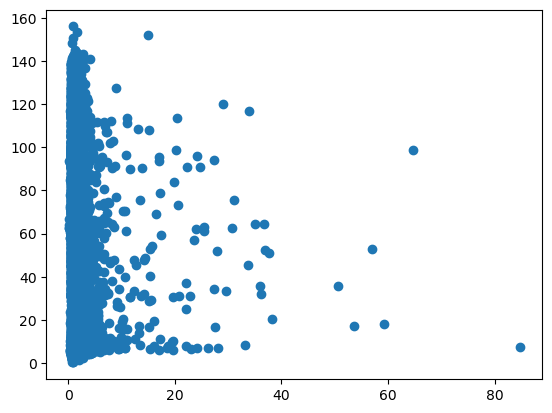

In [45]:
# plot
fig, ax = plt.subplots()

ax.scatter(df_time['delta_step_0_1'], df_time['ball_dist_to_center_cm'])

plt.show()

In [114]:
max(exposure_trials['exposure_trial_target'])

75

In [3]:
# 1) make sure the bin col is int
exposure_trials['trial_bin_target'] = (exposure_trials['exposure_trial_target'] - 1) // 5

# 2) bin-mean per ppid × target × bin
binned = (
    exposure_trials
      .groupby(['ppid', 'target_x_label', 'trial_bin_target','set_order'], observed=True)
      ['baseline_corrected_x']
      .agg(mean_error='mean', se_error='sem', n='size')
      .reset_index()
)

# check trial counts per bin
check_counts = (
    exposure_trials
      .groupby(['ppid','target_x_label','trial_bin_target'])
      .size()
)

print(check_counts.head(20))


NameError: name 'exposure_trials' is not defined

C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

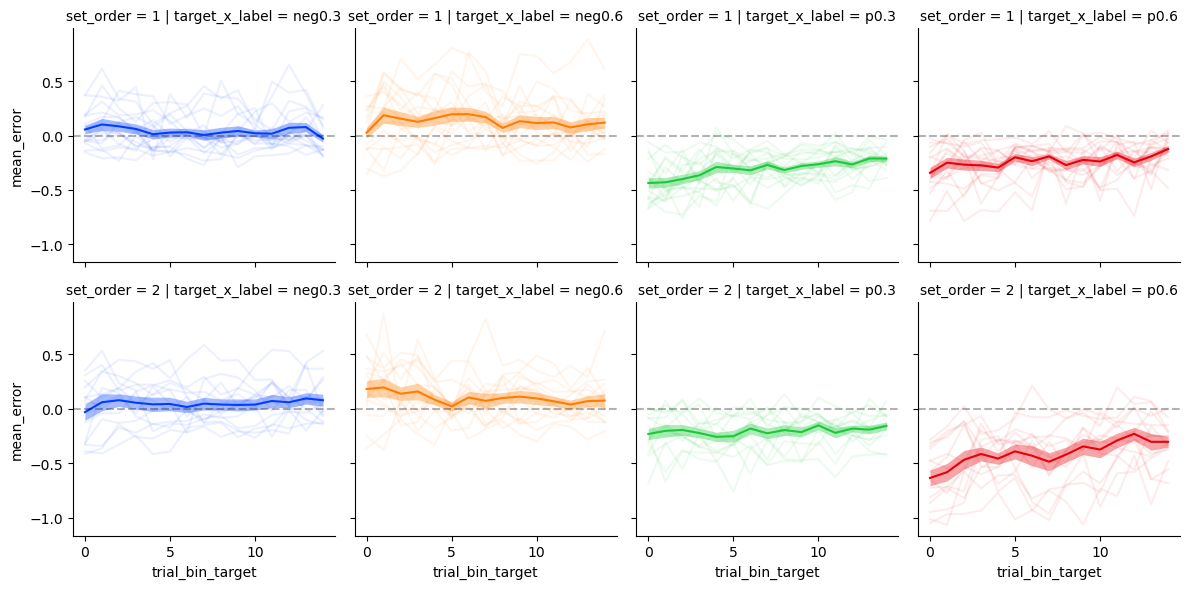

In [172]:
# set facets by target
g = sns.FacetGrid(binned, col='target_x_label', row='set_order', sharex=True, sharey=True)
# set Y lim to 110.0 cm
#g.set(ylim=(None, 110.0))

# individual data
g.map_dataframe(sns.lineplot,
                x='trial_bin_target', y='mean_error',
                estimator=None, units='ppid',
                hue = 'target_x_label', palette='bright',
                alpha=0.075)
# mean line and se bands
g.map_dataframe(sns.lineplot,
                x='trial_bin_target', y='mean_error',
                estimator='mean', errorbar='se', err_kws={'alpha':0.35, 'linewidth':0},
                hue = 'target_x_label', palette='bright', alpha=1)



# add horizontal line at error of 0
for ax in g.axes.flat:
    ax.axhline(y=0.0, color = 'black', linestyle='--', alpha = 0.3)


# Save and display
plt.savefig("test.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [527]:
# 1) make sure the bin col is int
washout_trials_still['trial_bin_target'] = (washout_trials_still['washout_trial_target'] - 1) // 8

# 2) bin-mean per ppid × target × bin
binned = (
    washout_trials_still
      .groupby(['ppid', 'target_x_label', 'trial_bin_target','set_order'], observed=True)
      ['baseline_corrected_x']
      .agg(mean_error='mean', se_error='sem', n='size')
      .reset_index()
)

# check trial counts per bin
check_counts = (
    washout_trials_still
      .groupby(['ppid','target_x_label','trial_bin_target'])
      .size()
)

print(check_counts.head(20))


ppid  target_x_label  trial_bin_target
p000  neg0.3          0                   4
                      1                   4
                      2                   4
                      3                   4
                      4                   4
      neg0.6          0                   4
                      1                   4
                      2                   4
                      3                   4
                      4                   4
      p0.3            0                   4
                      1                   4
                      2                   4
                      3                   4
                      4                   4
      p0.6            0                   4
                      1                   4
                      2                   4
                      3                   4
                      4                   4
dtype: int64


C:\Users\jacob\AppData\Local\Temp\ipykernel_29952\2975932187.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['ppid','target_x_label','trial_bin_target'])


In [521]:
# Example in pandas
washout_trials_still['error_signed'] = washout_trials_still['baseline_corrected_x']

# Flip sign for positive targets
washout_trials_still.loc[washout_trials_still["target_x_label"].isin(["p0.3", "p0.6"]), "error_signed"] *= 1
washout_trials_still

ppid  trial_num  trial_num_target  launch_deviation  launch_Speed  \
423    p000        425                89        -11.642927      3.383015   
425    p000        427                90        -10.057857      3.220239   
427    p000        429                91         -3.524727      3.436478   
430    p000        432                92         -8.581447      2.638650   
440    p000        442                97         -7.258397      2.950399   
...     ...        ...               ...               ...           ...   
15617  p037        258               116          1.329851      2.238340   
15627  p037        268               121          1.386511      2.482665   
15628  p037        269               122         -3.500079      2.086529   
15630  p037        271               123          4.836881      2.614344   
15632  p037        273               124         -1.011779      2.362442   

       ball_dist_to_center_cm target_hit  water_speed_binary  water_speed_m_s  \
423                 29.082605      False                   0                0   
425                 25.018275      False                   0                0   
427                  9.091502      False                   0                0   
430                 21.455958      False                   0                0   
440                 18.091278      False                   0                0   
...                       ...        ...                 ...              ...   
15617                6.177456       True                   0                0   
15627                5.991099       True                   0                0   
15628                9.431813      False                   0                0   
15630               12.900636      False                   0                0   
15632                5.805935       True                   0                0   

      target_x_label  ... baseline_dist_cm baseline_error_x  hit_rate  \
423           neg0.3  ...        17.120485         0.121472  0.384615   
425           neg0.3  ...        17.120485         0.121472  0.384615   
427           neg0.3  ...        17.120485         0.121472  0.384615   
430           neg0.3  ...        17.120485         0.121472  0.384615   
440           neg0.3  ...        17.120485         0.121472  0.384615   
...              ...  ...              ...              ...       ...   
15617           p0.6  ...        12.044657         0.061008  0.307692   
15627           p0.6  ...        12.044657         0.061008  0.307692   
15628           p0.6  ...        12.044657         0.061008  0.307692   
15630           p0.6  ...        12.044657         0.061008  0.307692   
15632           p0.6  ...        12.044657         0.061008  0.307692   

      baseline_corrected_dist baseline_corrected_x  block  \
423                 11.962120             0.167627      2   
425                  7.897790             0.129936      2   
427                 -8.028983            -0.029864      2   
430                  4.335473             0.093080      2   
440                  0.970793             0.062491      2   
...                       ...                  ...    ...   
15617               -5.867201            -0.125456      1   
15627               -6.053558            -0.126896      1   
15628               -2.612844             0.015226      1   
15630                0.855979            -0.199171      1   
15632               -6.238722            -0.072431      1   

       washout_trial_target  trial_bin_target  error_signed     bin_c  
423                       1                 0      0.167627 -1.991376  
425                       2                 0      0.129936 -1.991376  
427                       3                 0     -0.029864 -1.991376  
430                       4                 0      0.093080 -1.991376  
440                       9                 2      0.062491 -0.991376  
...                     ...               ...           ...       ...  
15617  

In [581]:
# 1) make sure the bin col is int

df_small_base = df_small.copy()

df_small_base = df_small_base[df_small_base['water_speed_binary'] == 0]
df_small_base = df_small_base[df_small_base['trial_num_target'] <= 13]

df_small_base['trial_bin_target'] = (df_small_base['trial_num_target'] - 1) // 4

# 2) bin-mean per ppid × target × bin
binned = (
    df_small_base
      .groupby(['ppid', 'target_x_label', 'trial_bin_target','set_order'], observed=True)
      ['baseline_corrected_x']
      .agg(mean_error='mean', se_error='sem', n='size')
      .reset_index()
)

# check trial counts per bin
check_counts = (
    df_small_base
      .groupby(['ppid','target_x_label','trial_bin_target'])
      .size()
)

print(check_counts.head(20))


ppid  target_x_label  trial_bin_target
p000  neg0.3          0                   4
                      1                   4
                      2                   4
                      3                   1
      neg0.6          0                   4
                      1                   4
                      2                   4
                      3                   1
      p0.3            0                   4
                      1                   4
                      2                   4
                      3                   0
      p0.6            0                   4
                      1                   4
                      2                   4
                      3                   1
p002  neg0.3          0                   4
                      1                   4
                      2                   4
                      3                   1
dtype: int64


C:\Users\jacob\AppData\Local\Temp\ipykernel_29952\1017833007.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['ppid','target_x_label','trial_bin_target'])


C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

<Figure size 1000x600 with 0 Axes>

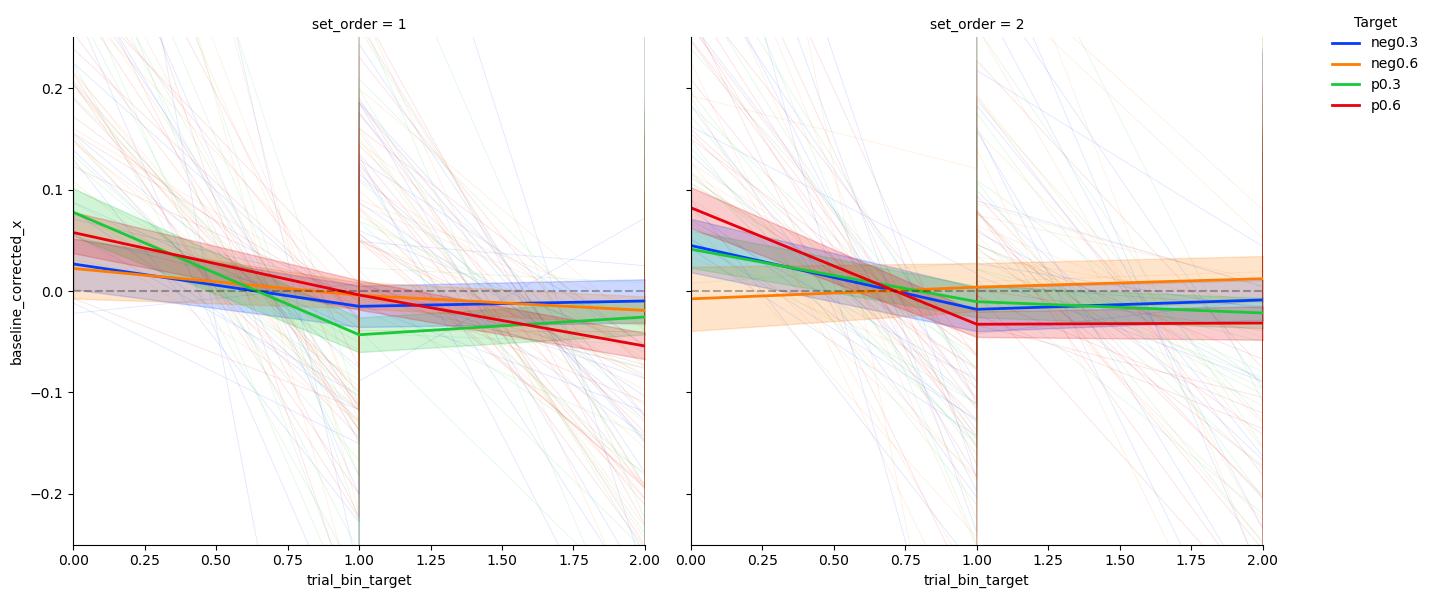

In [585]:


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
g = sns.FacetGrid(
    df_small_base,
    col = 'set_order',
    sharex=True, sharey=True,
    hue="target_x_label",      # set hue on the grid
    palette="bright", height=6
)

# spaghetti
g.map_dataframe(
    sns.lineplot,
    x="trial_bin_target", y="baseline_corrected_x",
    estimator=None, units="ppid",
    alpha=0.12, linewidth=0.6, legend=False
)

# mean ± SE
g.map_dataframe(
    sns.lineplot,
    x="trial_bin_target", y="baseline_corrected_x",
    estimator="mean", errorbar="se",
    linewidth=2
)

g.set(xlim=(0, 2), ylim=(-0.25,0.25))
for ax in g.axes.flat:
    ax.axhline(0, ls="--", c="k", alpha=0.3)

g.add_legend(title="Target", bbox_to_anchor=(1.02,1), loc="upper left")
g.figure.tight_layout()
g.figure.savefig("baseline_signed_onepanel.pdf", dpi=300, bbox_inches="tight")
plt.show()


C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

<Figure size 1000x600 with 0 Axes>

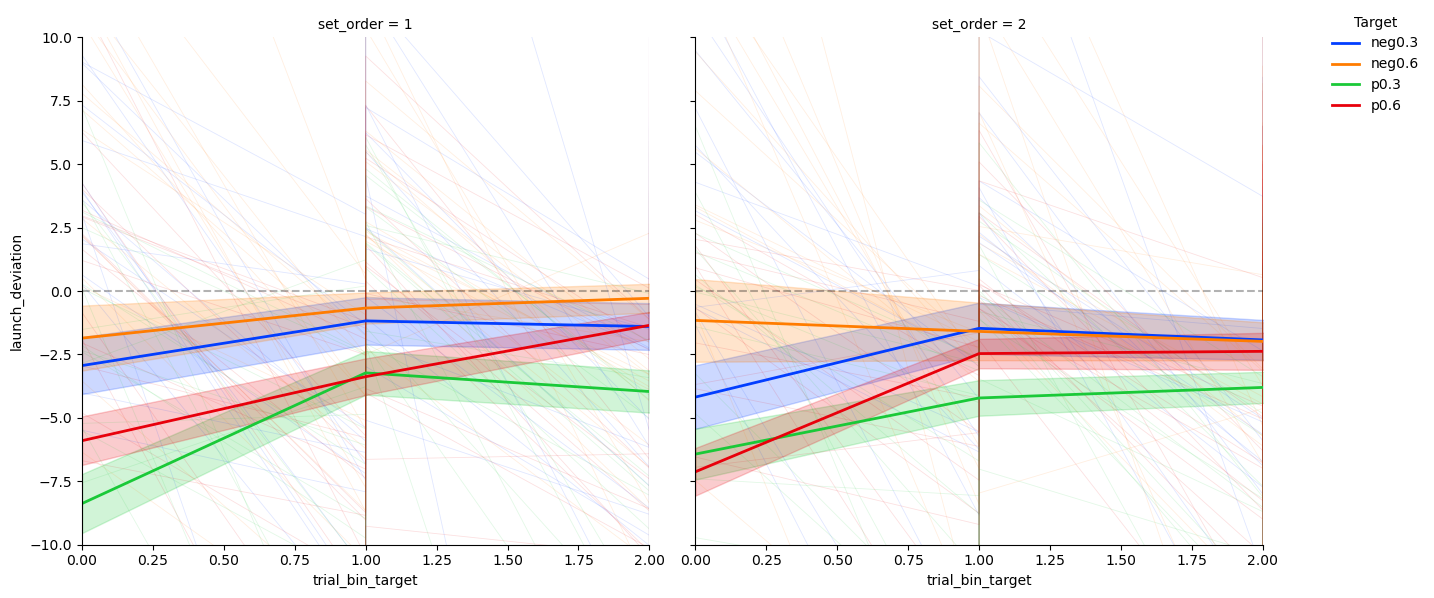

In [601]:


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
g = sns.FacetGrid(
    df_small_base,
    col = 'set_order',
    sharex=True, sharey=True,
    hue="target_x_label",      # set hue on the grid
    palette="bright", height=6
)

# spaghetti
g.map_dataframe(
    sns.lineplot,
    x="trial_bin_target", y="launch_deviation",
    estimator=None, units="ppid",
    alpha=0.12, linewidth=0.6, legend=False
)

# mean ± SE
g.map_dataframe(
    sns.lineplot,
    x="trial_bin_target", y="launch_deviation",
    estimator="mean", errorbar="se",
    linewidth=2
)

g.set(xlim=(0, 2), ylim=(-10.0,10.0))
for ax in g.axes.flat:
    ax.axhline(0, ls="--", c="k", alpha=0.3)

g.add_legend(title="Target", bbox_to_anchor=(1.02,1), loc="upper left")
g.figure.tight_layout()
g.figure.savefig("baseline_dev_onepanel.pdf", dpi=300, bbox_inches="tight")
plt.show()


C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

<Figure size 1000x600 with 0 Axes>

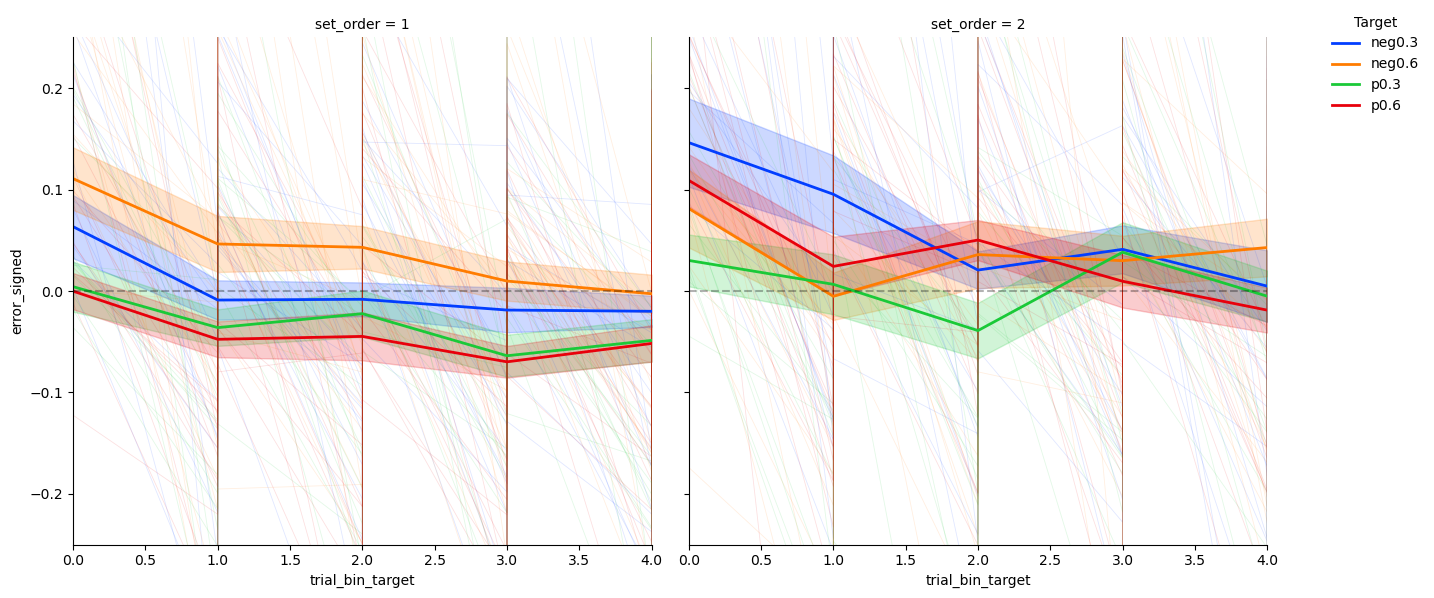

In [587]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
g = sns.FacetGrid(
    washout_trials_still,
    col = 'set_order',
    sharex=True, sharey=True,
    hue="target_x_label",      # set hue on the grid
    palette="bright", height=6
)

# spaghetti
g.map_dataframe(
    sns.lineplot,
    x="trial_bin_target", y="error_signed",
    estimator=None, units="ppid",
    alpha=0.12, linewidth=0.6, legend=False
)

# mean ± SE
g.map_dataframe(
    sns.lineplot,
    x="trial_bin_target", y="error_signed",
    estimator="mean", errorbar="se",
    linewidth=2
)

g.set(xlim=(0,4), ylim=(-0.25,0.25))
for ax in g.axes.flat:
    ax.axhline(0, ls="--", c="k", alpha=0.3)

g.add_legend(title="Target", bbox_to_anchor=(1.02,1), loc="upper left")
g.figure.tight_layout()
g.figure.savefig("washout_signed_onepanel.pdf", dpi=300, bbox_inches="tight")
plt.show()


C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
C:\Users\jacob\anaconda3\Lib\site-packages\seaborn\relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

<Figure size 1000x600 with 0 Axes>

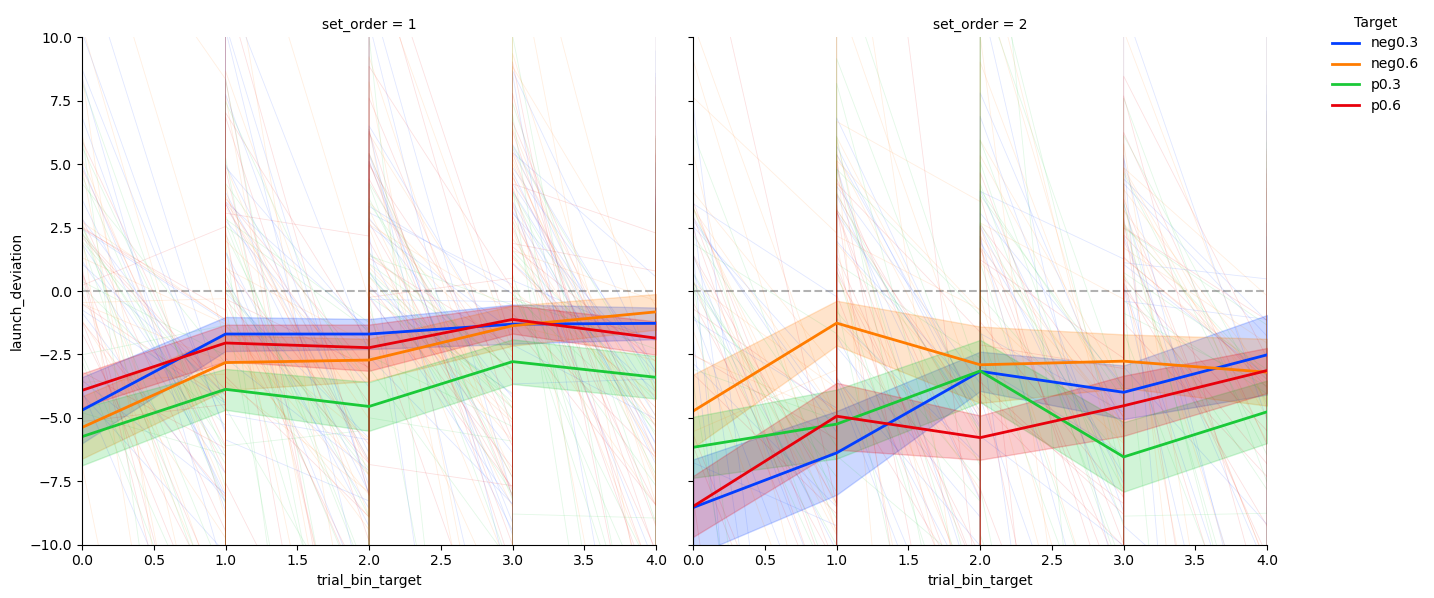

In [597]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
g = sns.FacetGrid(
    washout_trials_still,
    col = 'set_order',
    sharex=True, sharey=True,
    hue="target_x_label",      # set hue on the grid
    palette="bright", height=6
)

# spaghetti
g.map_dataframe(
    sns.lineplot,
    x="trial_bin_target", y="launch_deviation",
    estimator=None, units="ppid",
    alpha=0.12, linewidth=0.6, legend=False
)

# mean ± SE
g.map_dataframe(
    sns.lineplot,
    x="trial_bin_target", y="launch_deviation",
    estimator="mean", errorbar="se",
    linewidth=2
)

g.set(xlim=(0,4), ylim=(-10.0, 10.0))
for ax in g.axes.flat:
    ax.axhline(0, ls="--", c="k", alpha=0.3)

g.add_legend(title="Target", bbox_to_anchor=(1.02,1), loc="upper left")
g.figure.tight_layout()
g.figure.savefig("washout_dev_onepanel.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [472]:
# washout blocks first and end
#washout_trials_still_04 = washout_trials_still['trial_bin_target'].isin([0.0, 4.0])

washout_trials_still_04 = washout_trials_still[
    (washout_trials_still['trial_bin_target'] == 0.0) |
    (washout_trials_still['trial_bin_target'] == 4.0)
]
list(washout_trials_still.columns)

['ppid',
 'trial_num',
 'trial_num_target',
 'launch_deviation',
 'launch_Speed',
 'ball_dist_to_center_cm',
 'target_hit',
 'water_speed_binary',
 'water_speed_m_s',
 'target_x_label',
 'sign_label',
 'set_order',
 'training_status',
 'ball_pos_x',
 'ball_pos_z',
 'target_position_x',
 'target_position_z',
 'hit_state',
 'error_x_plane',
 'error_z_plane',
 'baseline_dist_cm',
 'baseline_error_x',
 'hit_rate',
 'baseline_corrected_dist',
 'baseline_corrected_x',
 'block',
 'washout_trial_target',
 'trial_bin_target',
 'error_signed',
 'bin_c']

In [442]:
# mixed model

washout_trials_still = washout_trials_still.copy()
washout_trials_still["bin_c"] = washout_trials_still["trial_bin_target"] - washout_trials_still["trial_bin_target"].mean()


m = smf.mixedlm(
    "error_signed ~ bin_c * C(target_x_label, Treatment(reference='p0.6'))",
    washout_trials_still,
    groups=washout_trials_still["ppid"]
)

print(m.fit().summary())


fit = m.fit()

C:\Users\jacob\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                                  Mixed Linear Model Regression Results
Model:                             MixedLM                Dependent Variable:                error_signed
No. Observations:                  2551                   Method:                            REML        
No. Groups:                        31                     Scale:                             0.0373      
Min. group size:                   78                     Log-Likelihood:                    516.0204    
Max. group size:                   158                    Converged:                         Yes         
Mean group size:                   82.3                                                                  
---------------------------------------------------------------------------------------------------------
                                                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------

C:\Users\jacob\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [448]:
m = smf.mixedlm(
    "error_signed ~ bin_c * C(target_x_label, Treatment(reference='p0.3'))",
    washout_trials_still,
    groups=washout_trials_still["ppid"]
)

print(m.fit().summary())


#fit = m.fit()

                                  Mixed Linear Model Regression Results
Model:                             MixedLM                Dependent Variable:                error_signed
No. Observations:                  2551                   Method:                            REML        
No. Groups:                        31                     Scale:                             0.0373      
Min. group size:                   78                     Log-Likelihood:                    516.0204    
Max. group size:                   158                    Converged:                         Yes         
Mean group size:                   82.3                                                                  
---------------------------------------------------------------------------------------------------------
                                                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------

C:\Users\jacob\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [506]:
import statsmodels.formula.api as smf

rob = smf.ols("error_signed ~ bin_c * C(target_x_label) * C(block)", washout_trials_still).fit(
    cov_type="cluster", cov_kwds={"groups": washout_trials_still["ppid"]}
)
print(rob.summary())


                            OLS Regression Results                            
Dep. Variable:           error_signed   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     8.833
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           2.80e-07
Time:                        18:16:59   Log-Likelihood:                 496.56
No. Observations:                2551   AIC:                            -961.1
Df Residuals:                    2535   BIC:                            -867.6
Df Model:                          15                                         
Covariance Type:              cluster                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------